In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import soundfile as sf

from configs.params_v1 import reorder_feats
from paths import DATA_DIR

import utils_ema.ema_dataset

from scipy.stats import pearsonr
from metrics import normalized_dtw_score
from utils import plot_art_14

from tqdm import tqdm

In [2]:
from text.converters import arpabet2ipa
from utils_dataset.mspka import mspka2ipa
from utils_dataset.pb2007 import pb20072ipa
from utils_dataset.mngu0 import mngu02ipa

lj_ipa_set = set(arpabet2ipa.values())

mspka_ipa = set(mspka2ipa.values())
extra_mspka_ipa = mspka_ipa - lj_ipa_set

pb2007_ipa = set(pb20072ipa.values())
extra_pb_ipa = pb2007_ipa - lj_ipa_set

mngu0_ipa = set(mngu02ipa.values())
extra_mngu0_ipa = mngu0_ipa - lj_ipa_set

dataset = "mocha_timit"
speakers = ["fsew0", "faet0", "ffes0", "maps0", "mjjn0", "msak0"]
mocha_ipa = []

version = "v1_1"
ckpt_name = "grad_3000"
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
    spk_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

    for i, row in spk_df.iterrows():
        sample_id = row["filestem"]
        phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
        for start, end, phnm in phnm3:
            if phnm not in mocha_ipa:
                mocha_ipa.append(phnm)
                
mocha_ipa = set(mocha_ipa)
extra_mocha_ipa = mocha_ipa - lj_ipa_set

dataset_2_extra_ipa = {
    "MSPKA_EMA_ita": extra_mspka_ipa,
    "pb2007": extra_pb_ipa,
    "MNGU0": extra_mngu0_ipa,
    "mocha_timit": extra_mocha_ipa,
}

In [3]:
versions_grads = {"v1" : ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"],
                  "v1_1": ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"],
                  "v1_" : ["grad_4750"],
                  "v2": ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000"],
                  "v3": ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000"],#, "grad_5000"],
                  "v4": ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"],
                  "v2_phnmtext": ["grad_1000", "grad_2000"],
                  "v4_phnmtext": ["grad_1000", "grad_2000"],
                  "v5": ["grad_1000", "grad_2000", "grad_3000"],
                  "v5_preblock": ["grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"]
                  }

score_cols = ['pcc_no_dtw', 'dtw_gt_enc', 'dtw_gt_dec', 'dtw_gt_sparc', 'dtw_sparc_enc', 'dtw_sparc_dec',
              'pcc_gt_enc', 'pcc_gt_dec', 'pcc_gt_sparc', 'pcc_sparc_enc', 'pcc_sparc_dec',
              'pred_rel_gap', 'enc_dtw_distortion', 'dec_dtw_distortion', 'sparc_dtw_distortion']

In [4]:
import utils_ema.ema_dataset

dataset = "pb2007"
processed_data_dir = DATA_DIR / dataset / "processed_data"
spkmetadata_filename = "1.0_speaker_metadata_100Hz.joblib"
# get the PCC scores of SPARC and other metadata for each sentence
spkmeta = joblib.load(processed_data_dir / f"spk1/{spkmetadata_filename}")
ids = spkmeta.list_valid_ids()
pcc_scores = []
filestems = []
splits = []
durations = []
for id in ids:
    sentencemeta = spkmeta.sentence_info[id]
    filestems.append(sentencemeta.filestem)
    splits.append(sentencemeta.split)
    pcc_scores.append(sentencemeta.PCC_score)
    durations.append(sentencemeta.duration)

summary_df = pd.DataFrame({
                            "filestem": filestems,
                            "split": splits,
                            "pcc": pcc_scores,
                            "duration": durations
                        })
if dataset == "pb2007":
    sentence_types = [spkmeta.sentence_info[id].sentence_type for id in ids]
    summary_df["sentence_types"] = sentence_types

sentence_filestems = list(summary_df[summary_df["sentence_types"] == "sentence"]["filestem"])

def get_specific_summary(dataset, speaker, version, ckpt_name, do_extra_ipa=False, remove_invalid=True):
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    short_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")
    if dataset == "pb2007":
        short_df = short_df[short_df["filestem"].isin(sentence_filestems)]
    #add count of extra ipa phnms that were absent during the train
    if do_extra_ipa:
        extra_ipa = dataset_2_extra_ipa[dataset]
        phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
        short_df["extra_ipa"] = 0

        for i, row in short_df.iterrows():
            sample_id = row["filestem"]
            phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
            for start, end, phnm in phnm3:
                if phnm in extra_ipa:
                    short_df.loc[i, "extra_ipa"] += 1
    if remove_invalid:
        original_len = len(short_df)
        if 'valid_enc' in short_df.columns:
            short_df = short_df[short_df["valid_enc"]]
        if 'valid_dec' in short_df.columns:
            short_df = short_df[short_df["valid_dec"]]
            #print(f"Removed {original_len - len(short_df)} invalid samples for {dataset} {speaker} {version} {ckpt_name}")
    return short_df

def create_dataset_summary(dataset, speakers, versions):
    dataset_summary = []
    for speaker in speakers:
        analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
        for version in versions:
            ckpt_names = versions_grads[version]
            for ckpt_name in ckpt_names:
                row = {
                    "speaker": speaker,
                    "version": version,
                    "ckpt_name": ckpt_name
                }
                #short_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")
                short_df = get_specific_summary(dataset, speaker, version, ckpt_name, do_extra_ipa=False)
                row["speaker"] = speaker
                row["version"] = version
                row["ckpt_name"] = ckpt_name
                short_means = short_df.describe().loc["mean"]
                for colname, v in zip(short_means.keys(), short_means.values):
                    row[colname] = v
                dataset_summary.append(row)

    dataset_summary = pd.DataFrame(dataset_summary)
    dataset_summary.rename(columns={"ckpt_name" : "epoch"}, inplace=True)
    dataset_summary["epoch"] = dataset_summary["epoch"].str.replace("grad_", "").astype(int)
    dataset_summary.drop(columns=["pcc", "duration"], inplace=True)
    return dataset_summary

def plot_speaker_scores(speaker, dataset, versions, dataset_summary, ref="gt", show_enc=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax = ax.flatten()
    spk_summary = dataset_summary[dataset_summary["speaker"] == speaker]
    print(f"Speaker {speaker} pcc_gt_sparc with/without dtw {spk_summary["pcc_gt_sparc"].values[0]:.3f} {spk_summary["pcc_no_dtw"].values[0]:.3f}")
    for i, version in enumerate(versions):
        version_summary = spk_summary[spk_summary["version"] == version]
        version_summary = version_summary.sort_values(by="epoch")
        if show_enc:
            ax[0].plot(version_summary["epoch"], version_summary[f"pcc_{ref}_enc"],marker="v", c=colors[i], linestyle="--")
        ax[0].plot(version_summary["epoch"], version_summary[f"pcc_{ref}_dec"],marker="o", c=colors[i], linestyle="-", label=f"{version} dec")
        ax[0].set_xlabel("Checkpoint Name")
        ax[0].set_ylabel("PCC")
        ax[0].set_title(f"Speaker {speaker} - {dataset}")
        ax[0].legend()
        ax[0].grid()
    ax[0].grid()
    
    print(f"Speaker {speaker} dtw_gt_sparc {spk_summary["dtw_gt_sparc"].values[0]:.3f}")
    for i, version in enumerate(versions):
        version_summary = spk_summary[spk_summary["version"] == version]
        version_summary = version_summary.sort_values(by="epoch")
        if show_enc:
            ax[1].plot(version_summary["epoch"], version_summary[f"dtw_{ref}_enc"],marker="v", c=colors[i], linestyle="--")
        ax[1].plot(version_summary["epoch"], version_summary[f"dtw_{ref}_dec"],marker="o", c=colors[i], linestyle="-", label=f"{version} dec")
        ax[1].set_xlabel("Checkpoint Name")
        ax[1].set_ylabel("DTW")
        ax[1].set_title(f"Speaker {speaker} - {dataset}")
        ax[1].legend()
        ax[1].grid()
    ax[1].grid()
    plt.tight_layout()
    

Quantitative evaluation of the arttts generated samples from the SPARC-extracted EMA features with the best and worst PCC score (Careful, may be influenced by the quality ofthe linear transfo. The PCC scores are computed on linearly transformed features (from MNGU0 space to concerned speaker) while the reconstruction takes an MNGU0-space input)

We want to assess how powerful the HiFi GAN is and how much it relies on accurate EMA/articulatory predictions.

We also test the sensitivity to pitch and speaker embedding

# MSPKA_EMA_ita

In [70]:
dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "lls", "olm"]
versions = ["v1", "v1_1", "v2", "v3", "v4", "v2_phnmtext", "v4_phnmtext", "v5", "v5_preblock"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
dataset_summary.head()


speaker version  epoch  pcc_no_dtw  dtw_gt_enc  dtw_gt_dec  dtw_gt_sparc  \
0     cnz      v1    200    0.773684    2.518845    2.490771      2.018662   
1     cnz      v1   1000    0.773684    2.531682    2.482307      2.018662   
2     cnz      v1   2000    0.773684    2.522390    2.468318      2.018662   
3     cnz      v1   3000    0.773684    2.513147    2.463830      2.018662   
4     cnz      v1   4000    0.773684    2.523650    2.466069      2.018662   

   dtw_sparc_enc  dtw_sparc_dec  pcc_gt_enc  pcc_gt_dec  pcc_gt_sparc  \
0       1.740926       1.714618    0.664259    0.669314      0.805161   
1       1.766518       1.705736    0.657906    0.669057      0.805161   
2       1.758295       1.692708    0.658736    0.671259      0.805161   
3       1.755363       1.696234    0.661866    0.672837      0.805161   
4       1.773108       1.699452    0.657768    0.670853      0.805161   

   pcc_sparc_enc  pcc_sparc_dec  pred_rel_gap  enc_dtw_distortion  \
0       0.770858       0.772015      0.129589            0.255918   
1       0.763640       0.773678      0.156571            0.235255   
2       0.765132       0.776928      0.175881            0.225508   
3       0.766082       0.775705      0.173749            0.225702   
4       0.761379       0.774387      0.177459            0.227626   

   dec_dtw_distortion  sparc_dtw_distortion  
0            0.269267              0.093497  
1            0.250711              0.093497  
2            0.241761              0.093497  
3            0.240962              0.093497  
4            0.242699              0.093497

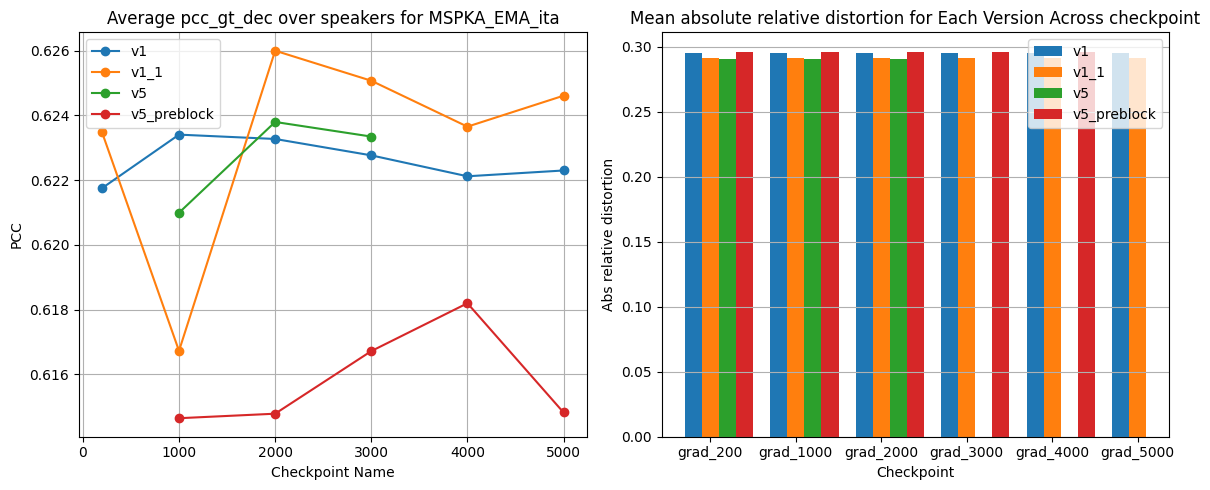

In [71]:
versions = ["v1", "v1_1", "v5", "v5_preblock"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
avg_summary = dataset_summary.groupby(["version", "epoch"]).mean(score_cols).reset_index() #average over speakers
avg_summary = avg_summary[["version", "epoch"] + score_cols]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
col = "pcc_gt_dec"
for version in versions:
    ax[0].plot(avg_summary[avg_summary["version"] == version]["epoch"],
             avg_summary[avg_summary["version"] == version][col],
             marker="o", label=version)
ax[0].set_xlabel("Checkpoint Name")
ax[0].set_ylabel("PCC")
ax[0].set_title(f"Average {col} over speakers for {dataset}")
ax[0].grid()
ax[0].legend()

#plotting mean absolute relative distortion by dtw
width = 0.2  # Bar width
#x = np.arange(len(datasets))  # Dataset positions
mean_scores = []
xs = []
for version in versions:
    means = []
    stds = []
    version_df = avg_summary[avg_summary["version"] == version]
    ckpts = versions_grads[version]
    xs.append(ckpts)
    for ckpt in ckpts:
        means.append(version_df["dec_dtw_distortion"].mean())
    mean_scores.append(means)

for i, version in enumerate(versions):
    x = np.arange(len(xs[i]))  # Update x positions for each version
    ax[1].bar(x + i * width, mean_scores[i], width, label=version, capsize=5)

# Add labels and legend
ax[1].set_xlabel("Checkpoint")
ax[1].set_ylabel("Abs relative distortion")
ax[1].set_title("Mean absolute relative distortion for Each Version Across checkpoint")
ax[1].set_xticks(np.arange(len(xs[0])) + width)
ax[1].set_xticklabels(xs[0])
ax[1].legend()
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

Speaker cnz pcc_gt_sparc with/without dtw 0.805 0.774
Speaker cnz dtw_gt_sparc 2.019
Speaker lls pcc_gt_sparc with/without dtw 0.673 0.627
Speaker lls dtw_gt_sparc 2.463
Speaker olm pcc_gt_sparc with/without dtw 0.782 0.752
Speaker olm dtw_gt_sparc 2.119


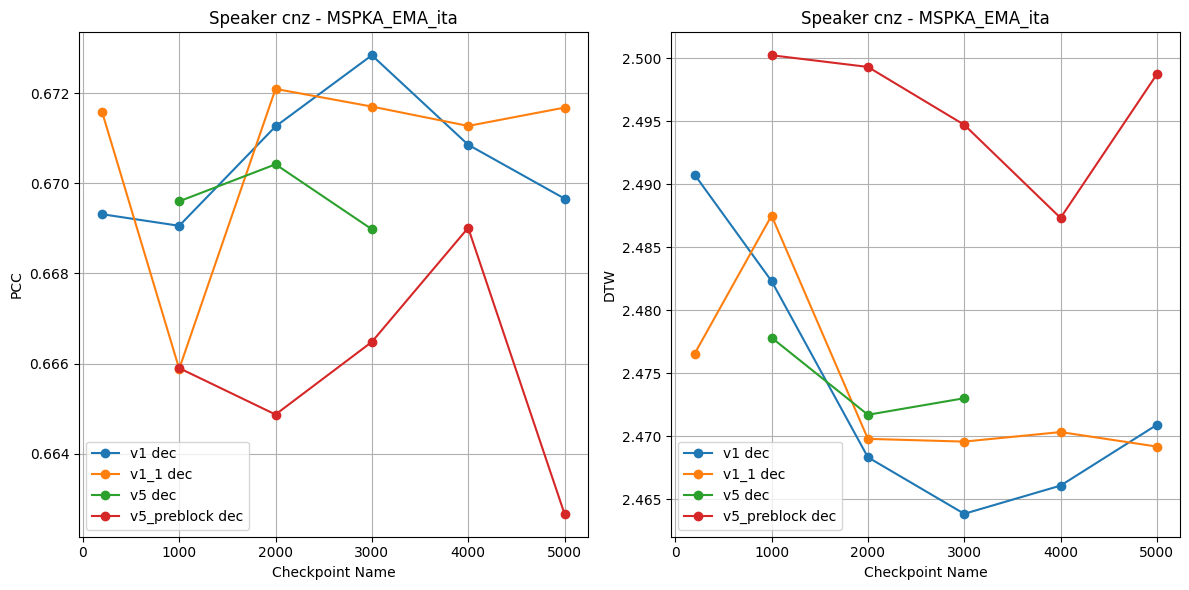

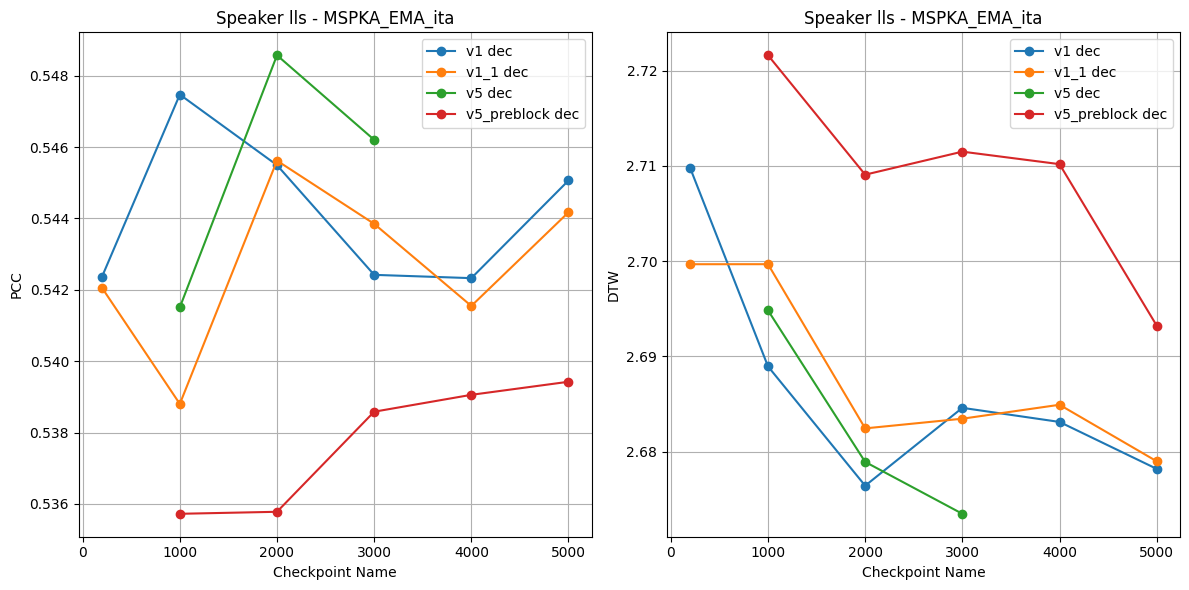

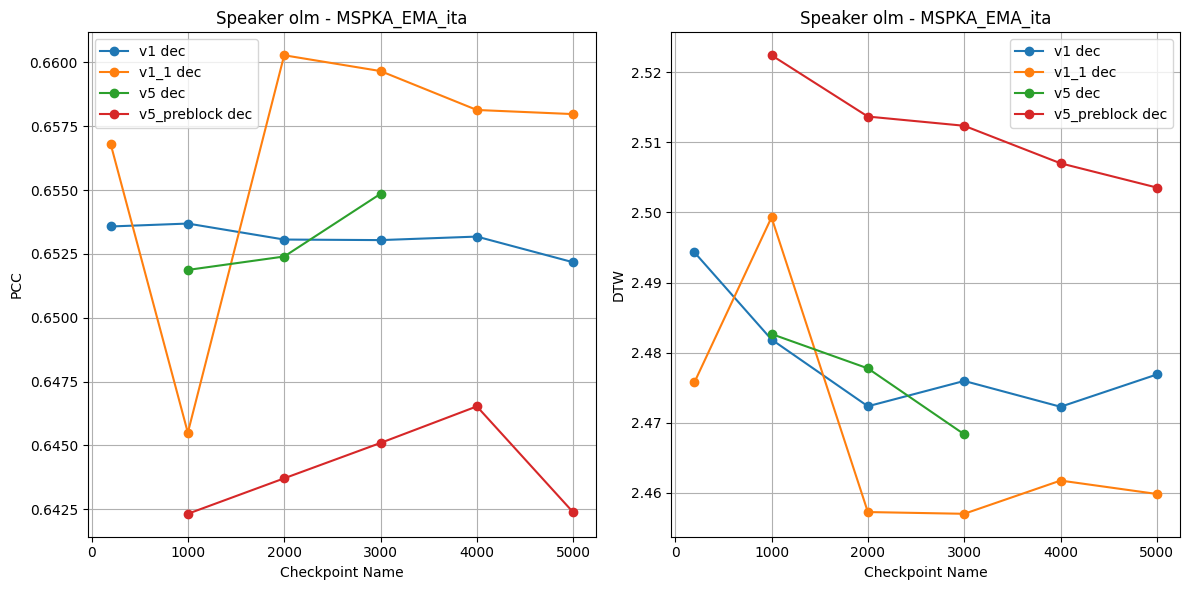

In [72]:
versions = ["v1", "v1_1", "v5", "v5_preblock"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]

plot_speaker_scores("cnz", dataset, versions, dataset_summary, ref="gt")
plot_speaker_scores("lls", dataset, versions, dataset_summary, ref="gt")
plot_speaker_scores("olm", dataset, versions, dataset_summary, ref="gt")

/tmp/ipykernel_284056/2032502021.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],


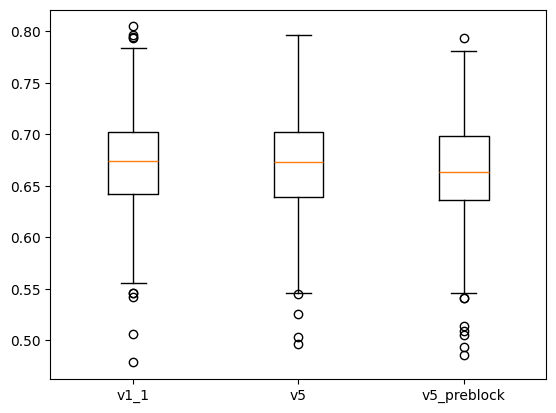

In [73]:
ckpt_name = "grad_2000"
versions = ["v1_1", "v5", "v5_preblock"]
speaker = "cnz"
versions_dfs = []

for version in versions:
    versions_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],
             labels=versions);

/tmp/ipykernel_284056/950958128.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],


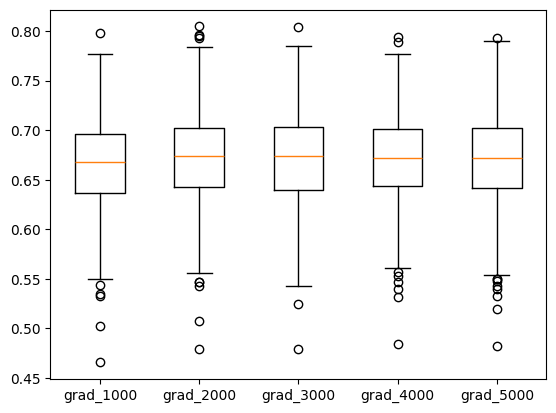

In [74]:
ckpt_names = ["grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"]
#ckpt_names = ["grad_1000", "grad_2000", "grad_3000"]
#versions = ["v1_1", "v5", "v5_preblock"]
version = "v1_1"
#version = "v5_preblock"
speaker = "cnz"
ckpt_names_dfs = []

for ckpt_name in ckpt_names:
    ckpt_names_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],
             labels=ckpt_names);

In [75]:
dataset_summary

speaker      version  epoch  pcc_no_dtw  dtw_gt_enc  dtw_gt_dec  \
0      cnz           v1    200    0.773684    2.518845    2.490771   
1      cnz           v1   1000    0.773684    2.531682    2.482307   
2      cnz           v1   2000    0.773684    2.522390    2.468318   
3      cnz           v1   3000    0.773684    2.513147    2.463830   
4      cnz           v1   4000    0.773684    2.523650    2.466069   
5      cnz           v1   5000    0.773684    2.525147    2.470896   
6      cnz         v1_1    200    0.773684    2.498575    2.476528   
7      cnz         v1_1   1000    0.773684    2.519580    2.487507   
8      cnz         v1_1   2000    0.773684    2.516998    2.469781   
9      cnz         v1_1   3000    0.773684    2.522769    2.469564   
10     cnz         v1_1   4000    0.773684    2.523616    2.470320   
11     cnz         v1_1   5000    0.773684    2.519927    2.469168   
12     cnz           v5   1000    0.773684    2.508789    2.477816   
13     cnz           v5   2000    0.773684    2.521029    2.471693   
14     cnz           v5   3000    0.773684    2.517182    2.473007   
15     cnz  v5_preblock   1000    0.773684    2.583893    2.500242   
16     cnz  v5_preblock   2000    0.773485    2.573479    2.499315   
17     cnz  v5_preblock   3000    0.773721    2.576655    2.494719   
18     cnz  v5_preblock   4000    0.773587    2.567516    2.487326   
19     cnz  v5_preblock   5000    0.773490    2.561639    2.498733   
20     lls           v1    200    0.627293    2.756769    2.709748   
21     lls           v1   1000    0.627293    2.760870    2.688939   
22     lls           v1   2000    0.627293    2.749097    2.676412   
23     lls           v1   3000    0.627293    2.746245    2.684592   
24     lls           v1   4000    0.627293    2.754226    2.683112   
25     lls           v1   5000    0.627293    2.756375    2.678184   
26     lls         v1_1    200    0.627293    2.730500    2.699675   
27     lls         v1_1   1000    0.627293    2.746273    2.699678   
28     lls         v1_1   2000    0.627293    2.749700    2.682435   
29     lls         v1_1   3000    0.627293    2.753260    2.683450   
30     lls         v1_1   4000    0.627293    2.754226    2.684915   
31     lls         v1_1   5000    0.627293    2.744577    2.678981   
32     lls           v5   1000    0.627103    2.737736    2.694824   
33     lls           v5   2000    0.627361    2.749807    2.678912   
34     lls           v5   3000    0.627293    2.736929    2.673464   
35     lls  v5_preblock   1000    0.627333    2.803447    2.721620   
36     lls  v5_preblock   2000    0.627609    2.788670    2.709079   
37     lls  v5_preblock   3000    0.627273    2.797195    2.711497   
38     lls  v5_preblock   4000    0.627133    2.794273    2.710185   
39     lls  v5_preblock   5000    0.627286    2.776780    2.693232   
40     olm           v1    200    0.751822    2.569338    2.494299   
41     olm           v1   1000    0.751822    2.593241    2.481868   
42     olm           v1   2000    0.751822    2.582321    2.472346   
43     olm           v1   3000    0.751822    2.570556    2.475958   
44     olm           v1   4000    0.751822    2.575310    2.472275   
45     olm           v1   5000    0.751822    2.586681    2.476882   
46     olm         v1_1    200    0.751822    2.531465    2.475772   
47     olm         v1_1   1000    0.751822    2.565622    2.499290   
48     olm         v1_1   2000    0.751822    2.564996    2.457257   
49     olm         v1_1   3000    0.751822    2.558110    2.457007   
50     olm         v1_1   4000    0.751822    2.565427    2.461747   
51     olm         v1_1   5000    0.751822    2.549299    2.459834   
52     olm           v5   1000    0.751822    2.542721    2.482652   
53     olm           v5   2000    0.751822    2.581141    2.477751   
54     olm           v5   3000    0.751822    2.565388    2.468346   
55     olm  v5_preblock   1000    0.751822    2.670588    2.522415   
56     olm  v

In [76]:
truc = dataset_summary[(dataset_summary["version"] == "v1_1") & (dataset_summary["epoch"] == 2000)]
truc[["speaker", "pcc_gt_dec", "pcc_sparc_dec"]]
print(truc[["pcc_gt_dec"]].mean())
print(truc[["pcc_sparc_dec"]].mean())

pcc_gt_dec    0.625996
dtype: float64
pcc_sparc_dec    0.744805
dtype: float64


# pb2007

In [77]:
dataset = "pb2007"
speakers = ["spk1"]
versions = ["v1", "v1_1", "v5", "v5_preblock"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
dataset_summary.head()

speaker version  epoch  pcc_no_dtw  dtw_gt_enc  dtw_gt_dec  dtw_gt_sparc  \
0    spk1      v1    200    0.678072    2.750546    2.750199      2.489608   
1    spk1      v1   1000    0.678072    2.758073    2.738253      2.489608   
2    spk1      v1   2000    0.678072    2.752510    2.719253      2.489608   
3    spk1      v1   3000    0.678072    2.754874    2.730352      2.489608   
4    spk1      v1   4000    0.678072    2.761639    2.730093      2.489608   

   dtw_sparc_enc  dtw_sparc_dec  pcc_gt_enc  pcc_gt_dec  pcc_gt_sparc  \
0       1.380698       1.358089    0.592751    0.587923      0.714803   
1       1.395574       1.338603    0.579942    0.587092      0.714803   
2       1.390010       1.332536    0.579701    0.589214      0.714803   
3       1.382811       1.327250    0.579428    0.585397      0.714803   
4       1.391816       1.329246    0.575825    0.585464      0.714803   

   pcc_sparc_enc  pcc_sparc_dec  pred_rel_gap  enc_dtw_distortion  \
0       0.730881       0.736305      0.123010            0.161387   
1       0.724547       0.739555      0.142112            0.135393   
2       0.725978       0.741558      0.166601            0.119701   
3       0.728415       0.742565      0.161430            0.120314   
4       0.725233       0.742451      0.170152            0.129863   

   dec_dtw_distortion  sparc_dtw_distortion  
0            0.174209              0.059422  
1            0.145457              0.059422  
2            0.139292              0.059422  
3            0.139659              0.059422  
4            0.148677              0.059422

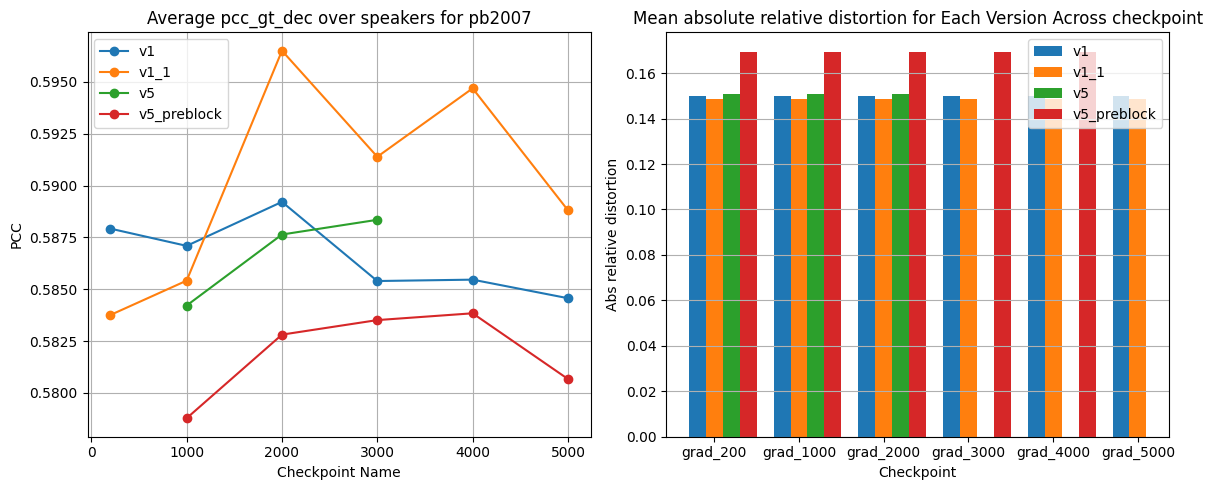

In [78]:
versions = ["v1", "v1_1", "v5", "v5_preblock"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
avg_summary = dataset_summary.groupby(["version", "epoch"]).mean(score_cols).reset_index() #average over speakers
avg_summary = avg_summary[["version", "epoch"] + score_cols]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
col = "pcc_gt_dec"
for version in versions:
    ax[0].plot(avg_summary[avg_summary["version"] == version]["epoch"],
             avg_summary[avg_summary["version"] == version][col],
             marker="o", label=version)
ax[0].set_xlabel("Checkpoint Name")
ax[0].set_ylabel("PCC")
ax[0].set_title(f"Average {col} over speakers for {dataset}")
ax[0].grid()
ax[0].legend()

#plotting mean absolute relative distortion by dtw
width = 0.2  # Bar width
#x = np.arange(len(datasets))  # Dataset positions
mean_scores = []
xs = []
for version in versions:
    means = []
    stds = []
    version_df = avg_summary[avg_summary["version"] == version]
    ckpts = versions_grads[version]
    xs.append(ckpts)
    for ckpt in ckpts:
        means.append(version_df["dec_dtw_distortion"].mean())
    mean_scores.append(means)

for i, version in enumerate(versions):
    x = np.arange(len(xs[i]))  # Update x positions for each version
    ax[1].bar(x + i * width, mean_scores[i], width, label=version, capsize=5)

# Add labels and legend
ax[1].set_xlabel("Checkpoint")
ax[1].set_ylabel("Abs relative distortion")
ax[1].set_title("Mean absolute relative distortion for Each Version Across checkpoint")
ax[1].set_xticks(np.arange(len(xs[0])) + width)
ax[1].set_xticklabels(xs[0])
ax[1].legend()
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

Speaker spk1 pcc_gt_sparc with/without dtw 0.715 0.678
Speaker spk1 dtw_gt_sparc 2.490


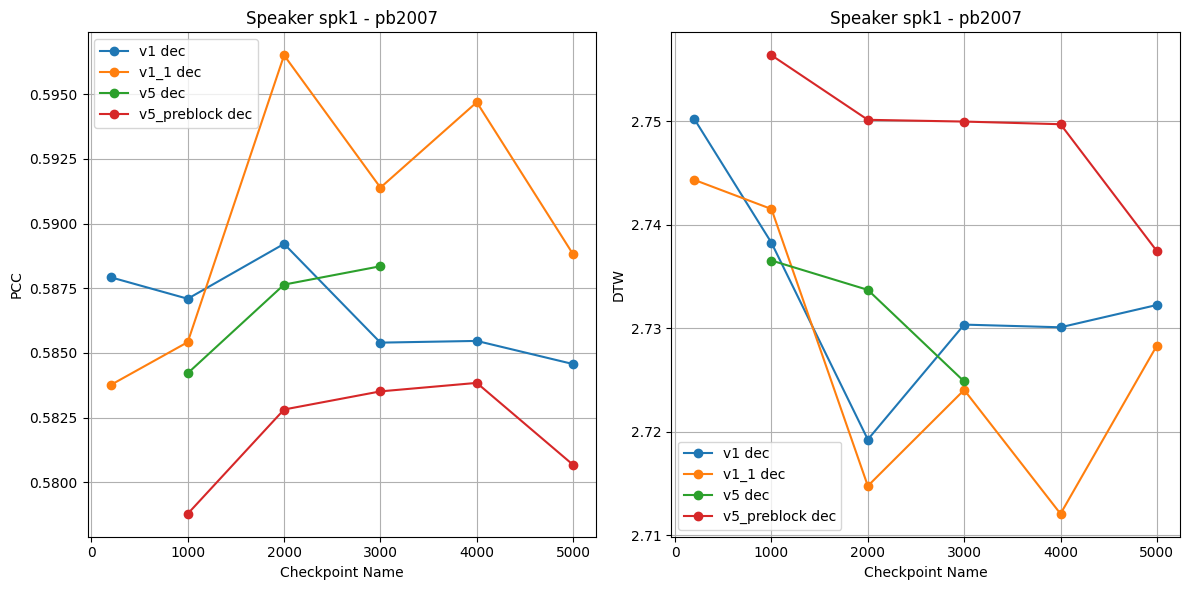

In [79]:
versions = ["v1", "v1_1", "v5", "v5_preblock"]

plot_speaker_scores("spk1", dataset, versions, dataset_summary, ref="gt")

/tmp/ipykernel_284056/618355705.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],


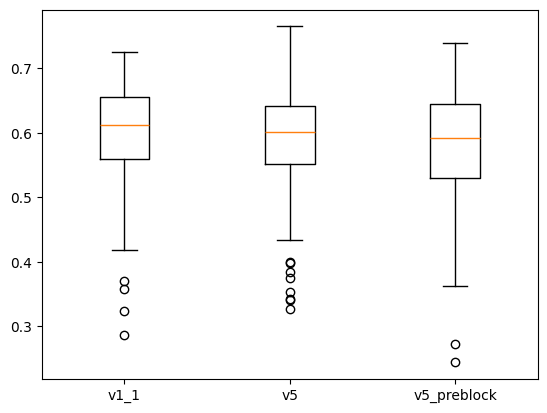

In [80]:
ckpt_name = "grad_2000"
versions = ["v1_1", "v5", "v5_preblock"]
speaker = "spk1"
versions_dfs = []

for version in versions:
    versions_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],
             labels=versions);

/tmp/ipykernel_284056/386195062.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],


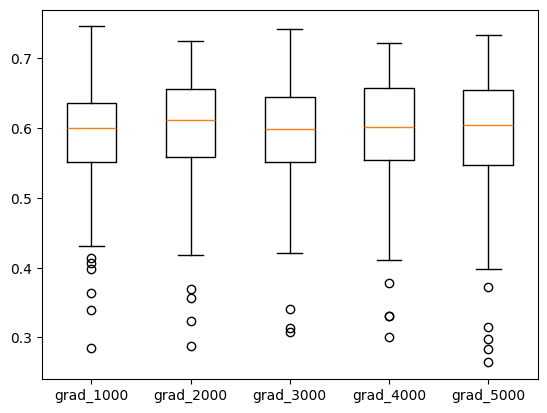

In [81]:
ckpt_names = ["grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"]
#ckpt_names = ["grad_1000", "grad_2000", "grad_3000"]
#versions = ["v1_1", "v5", "v5_preblock"]
version = "v1_1"
#version = "v5_preblock"
speaker = "spk1"
ckpt_names_dfs = []

for ckpt_name in ckpt_names:
    ckpt_names_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],
             labels=ckpt_names);

In [82]:
truc = dataset_summary[(dataset_summary["version"] == "v1_1") & (dataset_summary["epoch"] == 2000)]
truc[["speaker", "pcc_gt_dec", "pcc_sparc_dec"]]
print(truc[["pcc_gt_dec"]].mean())
print(truc[["pcc_sparc_dec"]].mean())

pcc_gt_dec    0.596502
dtype: float64
pcc_sparc_dec    0.75399
dtype: float64


# mocha_timit

In [59]:
dataset = "mocha_timit"
speakers = ["faet0", "fsew0", "ffes0", "maps0", "msak0", "mjjn0"]
versions = ["v1", "v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext", "v5", "v5_preblock"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
dataset_summary.head()

speaker version  epoch  pcc_no_dtw  dtw_gt_enc  dtw_gt_dec  dtw_gt_sparc  \
0   faet0      v1    200    0.696867    2.739990    2.728801      2.370316   
1   faet0      v1   1000    0.696867    2.743114    2.700853      2.370316   
2   faet0      v1   2000    0.696867    2.746902    2.692747      2.370316   
3   faet0      v1   3000    0.696867    2.749667    2.692284      2.370316   
4   faet0      v1   4000    0.696867    2.751257    2.691565      2.370316   

   dtw_sparc_enc  dtw_sparc_dec  pcc_gt_enc  pcc_gt_dec  pcc_gt_sparc  \
0       1.611422       1.602207    0.593495    0.596915      0.705032   
1       1.623234       1.558681    0.591143    0.605104      0.705032   
2       1.624252       1.542381    0.589473    0.608884      0.705032   
3       1.635877       1.542476    0.589588    0.608947      0.705032   
4       1.638188       1.543972    0.589025    0.608377      0.705032   

   pcc_sparc_enc  pcc_sparc_dec  pred_rel_gap  enc_dtw_distortion  \
0       0.719817       0.718084      0.133978            0.333720   
1       0.718039       0.733810      0.130151            0.326923   
2       0.717176       0.739505      0.127185            0.321497   
3       0.714835       0.739254      0.126845            0.324037   
4       0.713316       0.738373      0.128910            0.327047   

   dec_dtw_distortion  sparc_dtw_distortion  
0            0.342065              0.057716  
1            0.336670              0.057716  
2            0.328313              0.057716  
3            0.332822              0.057716  
4            0.336898              0.057716

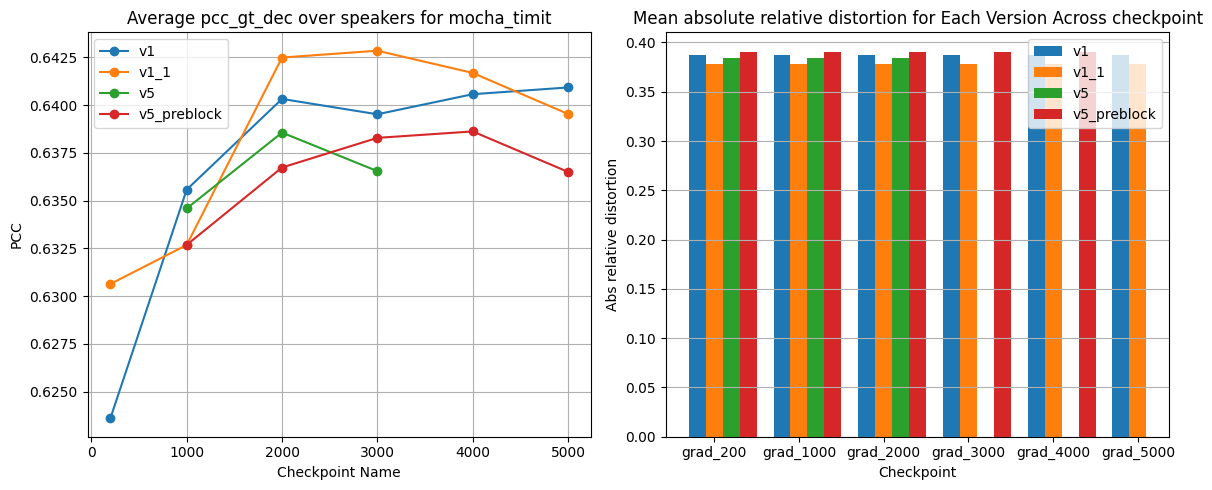

In [60]:
versions = ["v1", "v1_1", "v5", "v5_preblock"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
avg_summary = dataset_summary.groupby(["version", "epoch"]).mean(score_cols).reset_index() #average over speakers
avg_summary = avg_summary[["version", "epoch"] + score_cols]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
col = "pcc_gt_dec"
for version in versions:
    ax[0].plot(avg_summary[avg_summary["version"] == version]["epoch"],
             avg_summary[avg_summary["version"] == version][col],
             marker="o", label=version)
ax[0].set_xlabel("Checkpoint Name")
ax[0].set_ylabel("PCC")
ax[0].set_title(f"Average {col} over speakers for {dataset}")
ax[0].grid()
ax[0].legend()

#plotting mean absolute relative distortion by dtw
width = 0.2  # Bar width
#x = np.arange(len(datasets))  # Dataset positions
mean_scores = []
xs = []
for version in versions:
    means = []
    stds = []
    version_df = avg_summary[avg_summary["version"] == version]
    ckpts = versions_grads[version]
    xs.append(ckpts)
    for ckpt in ckpts:
        means.append(version_df["dec_dtw_distortion"].mean())
    mean_scores.append(means)

for i, version in enumerate(versions):
    x = np.arange(len(xs[i]))  # Update x positions for each version
    ax[1].bar(x + i * width, mean_scores[i], width, label=version, capsize=5)

# Add labels and legend
ax[1].set_xlabel("Checkpoint")
ax[1].set_ylabel("Abs relative distortion")
ax[1].set_title("Mean absolute relative distortion for Each Version Across checkpoint")
ax[1].set_xticks(np.arange(len(xs[0])) + width)
ax[1].set_xticklabels(xs[0])
ax[1].legend()
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

Speaker faet0 pcc_gt_sparc with/without dtw 0.705 0.697
Speaker faet0 dtw_gt_sparc 2.370
Speaker fsew0 pcc_gt_sparc with/without dtw 0.744 0.739
Speaker fsew0 dtw_gt_sparc 2.259
Speaker ffes0 pcc_gt_sparc with/without dtw 0.767 0.758
Speaker ffes0 dtw_gt_sparc 2.184
Speaker maps0 pcc_gt_sparc with/without dtw 0.746 0.729
Speaker maps0 dtw_gt_sparc 2.234
Speaker msak0 pcc_gt_sparc with/without dtw 0.765 0.751
Speaker msak0 dtw_gt_sparc 2.155
Speaker mjjn0 pcc_gt_sparc with/without dtw 0.734 0.725
Speaker mjjn0 dtw_gt_sparc 2.268


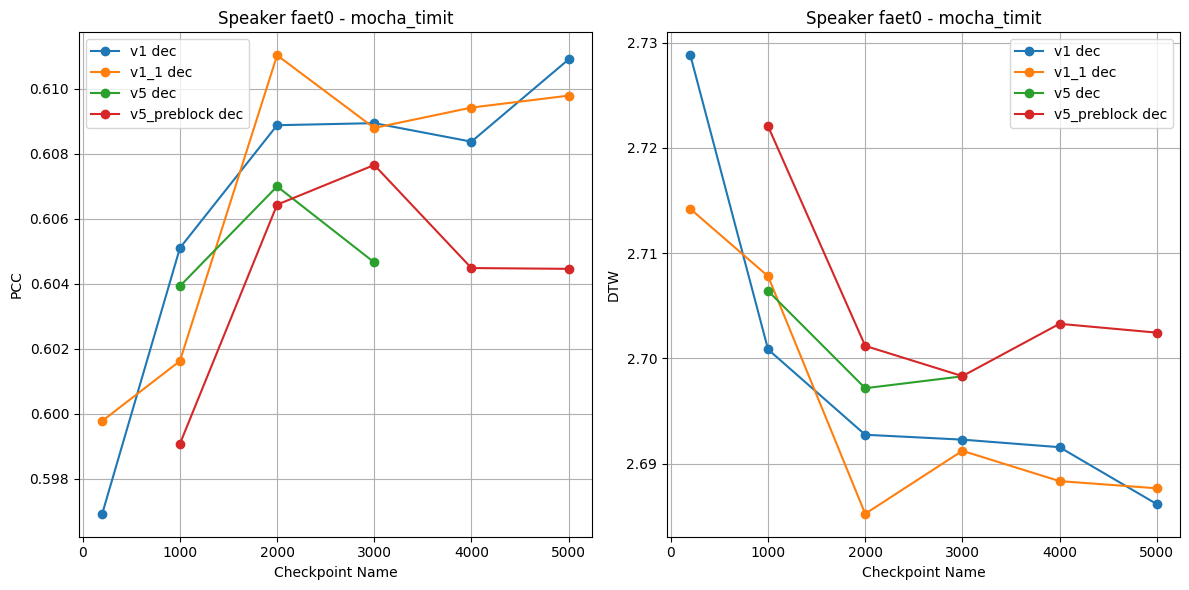

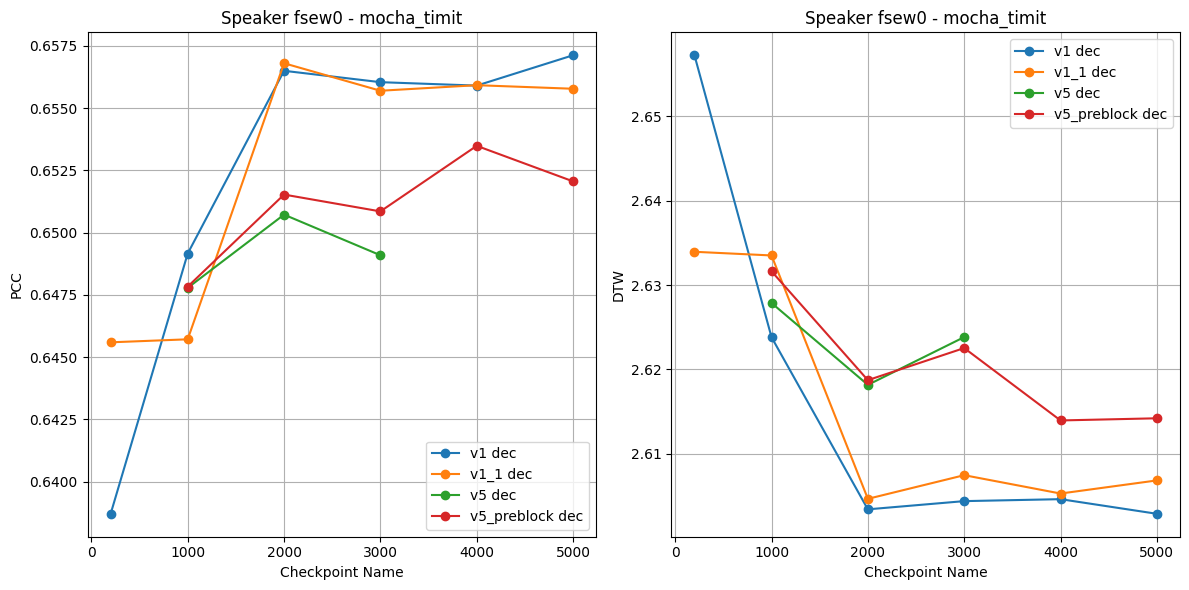

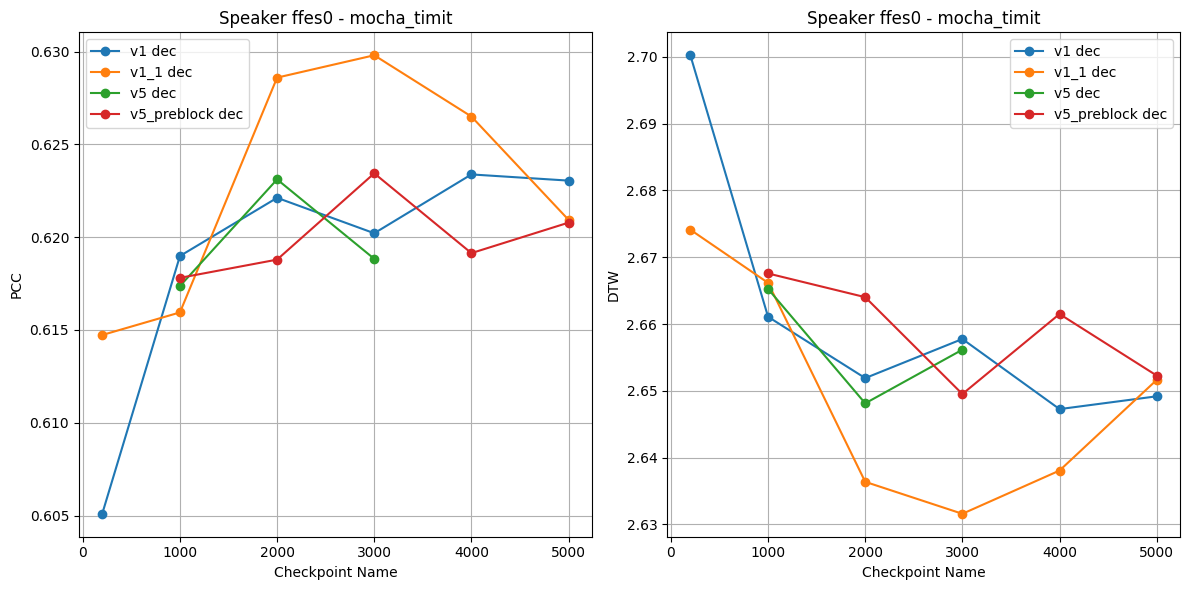

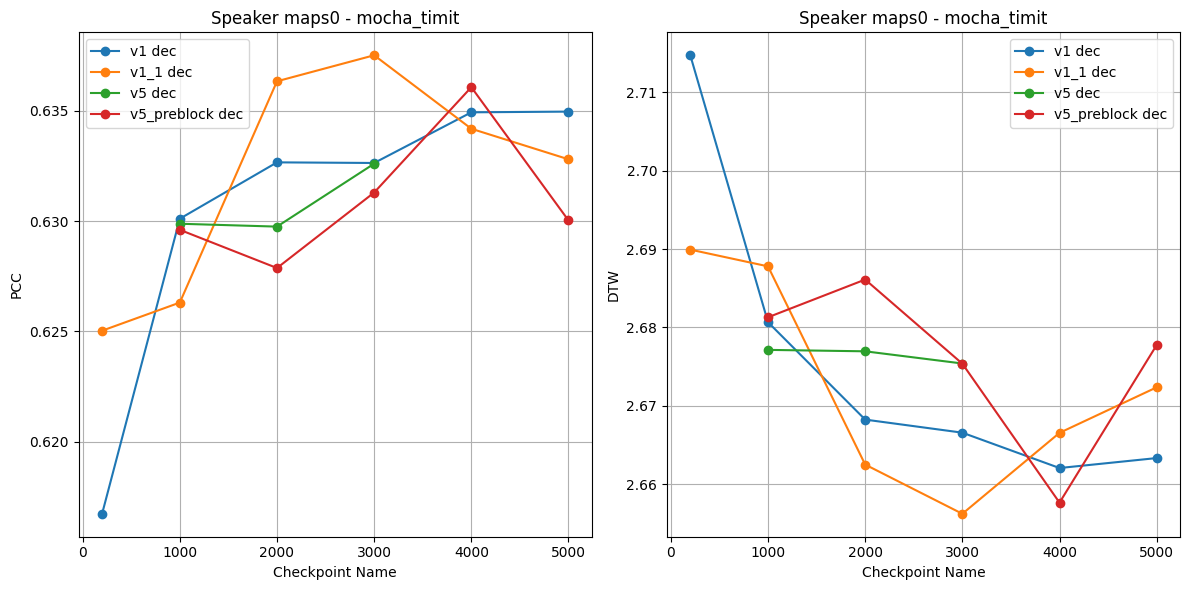

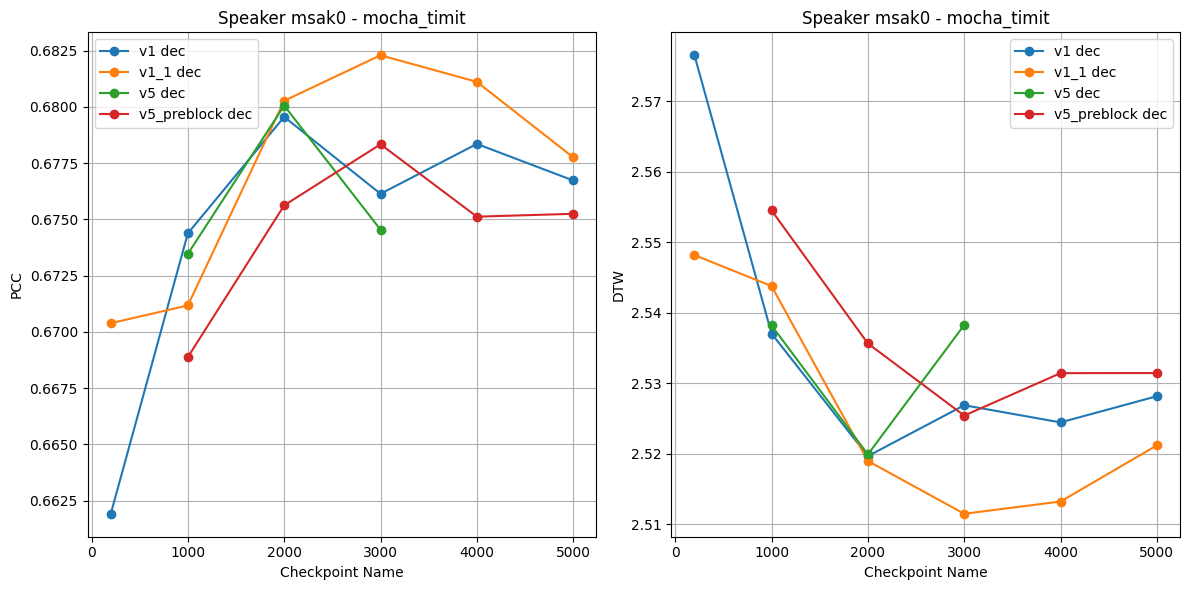

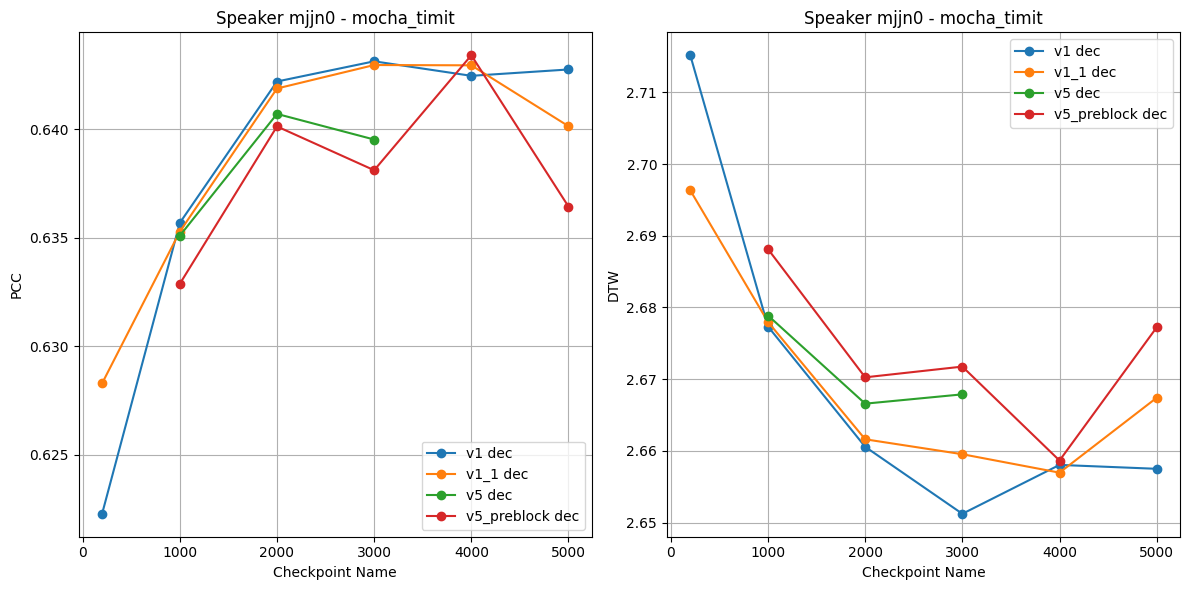

In [61]:
versions = ["v1", "v1_1", "v5", "v5_preblock"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]

for spk in speakers:
    plot_speaker_scores(spk, dataset, versions, dataset_summary, ref="gt")

/tmp/ipykernel_284056/347230761.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],


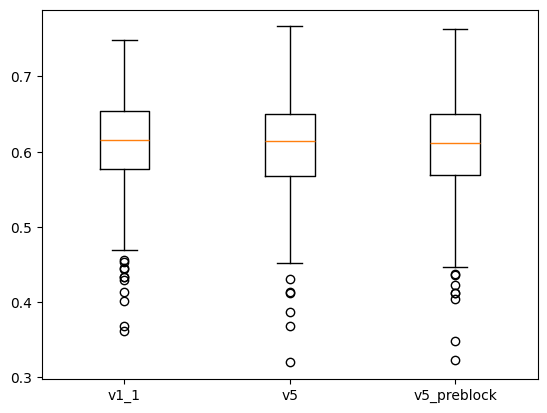

In [62]:
ckpt_name = "grad_2000"
versions = ["v1_1", "v5", "v5_preblock"]
speaker = "faet0"
versions_dfs = []

for version in versions:
    versions_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],
             labels=versions);

/tmp/ipykernel_284056/1838301735.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],


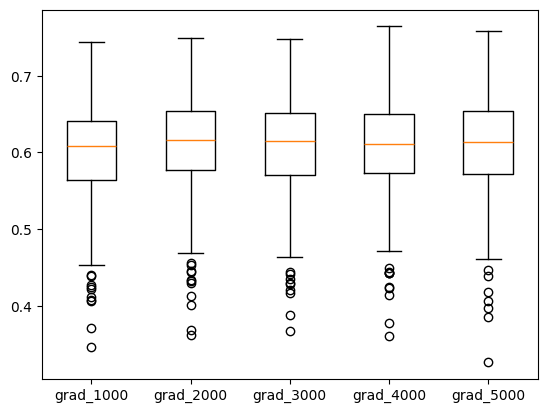

In [63]:
ckpt_names = ["grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"]
#ckpt_names = ["grad_1000", "grad_2000", "grad_3000"]
#versions = ["v1_1", "v5", "v5_preblock"]
version = "v1_1"
#version = "v5_preblock"
speaker = "faet0"
ckpt_names_dfs = []

for ckpt_name in ckpt_names:
    ckpt_names_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],
             labels=ckpt_names);

In [68]:
truc = dataset_summary[(dataset_summary["version"] == "v1_1") & (dataset_summary["epoch"] == 2000)]
truc[["speaker", "pcc_gt_dec", "pcc_sparc_dec"]]
print(truc[["pcc_gt_dec"]].mean())
print(truc[["pcc_sparc_dec"]].mean())

pcc_gt_dec    0.642489
dtype: float64
pcc_sparc_dec    0.757207
dtype: float64


pcc_gt_dec    0.642489
dtype: float64
pcc_sparc_dec    0.757207
dtype: float64


# MNGU0

In [17]:
df = get_specific_summary("MNGU0", "s1", "v1_1", "grad_3000")[["filestem", "pcc"]]
print(df["pcc"].mean())
print(1.96 * df["pcc"].std()/(df.shape[0]**0.5))

0.854605064477499
0.0030802883698280823


In [5]:
dataset = "MNGU0"
speakers = ["s1"]
versions = ["v1", "v1_1", "v1_", "v2", "v4", "v2_phnmtext", "v4_phnmtext", "v5", "v5_preblock"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
dataset_summary.head()

speaker version  epoch  pcc_no_dtw  dtw_gt_enc  dtw_gt_dec  dtw_gt_sparc  \
0      s1      v1    200    0.854605    2.550461    2.750706      1.772634   
1      s1      v1   1000    0.854605    2.567823    2.620048      1.772634   
2      s1      v1   2000    0.854605    2.571979    2.572175      1.772634   
3      s1      v1   3000    0.854605    2.579332    2.582614      1.772634   
4      s1      v1   4000    0.854605    2.581140    2.578950      1.772634   

   dtw_sparc_enc  dtw_sparc_dec  pcc_gt_enc  pcc_gt_dec  pcc_gt_sparc  \
0       2.232645       2.413423    0.764562    0.761317      0.874679   
1       2.250609       2.250678    0.763146    0.771524      0.874679   
2       2.251081       2.197259    0.763456    0.776534      0.874679   
3       2.263969       2.208045    0.763486    0.776444      0.874679   
4       2.266069       2.210204    0.761425    0.774602      0.874679   

   pcc_sparc_enc  pcc_sparc_dec  pred_rel_gap  enc_dtw_distortion  \
0       0.803046       0.802378      0.158960            0.361744   
1       0.801437       0.816951      0.153076            0.351960   
2       0.802354       0.822339      0.151655            0.349056   
3       0.800640       0.821878      0.156943            0.355783   
4       0.798141       0.819382      0.159972            0.358861   

   dec_dtw_distortion  sparc_dtw_distortion  
0            0.371393              0.083072  
1            0.366175              0.083072  
2            0.362462              0.083072  
3            0.370631              0.083072  
4            0.374388              0.083072

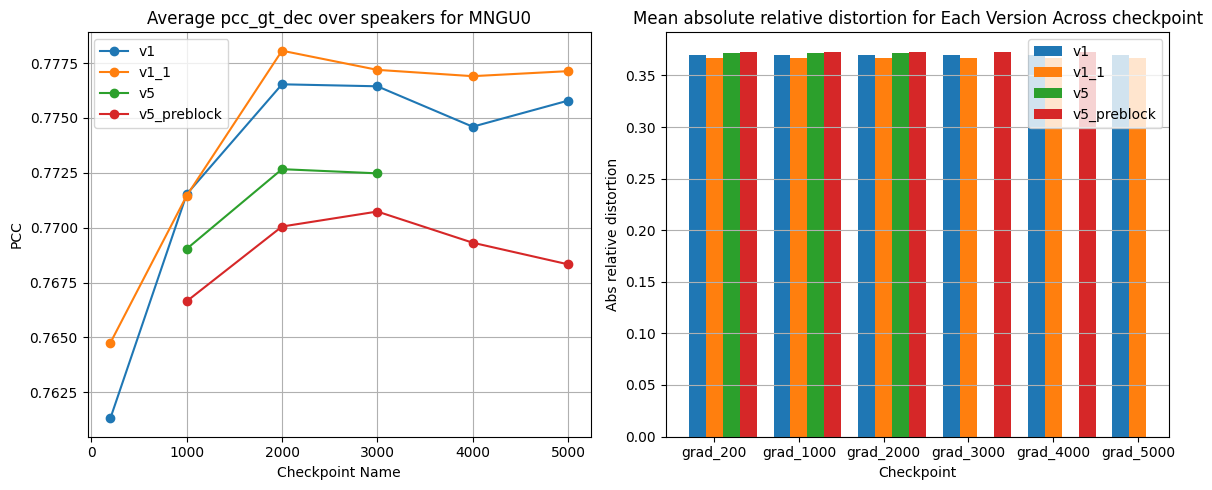

In [6]:
versions = ["v1", "v1_1","v5", "v5_preblock"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
avg_summary = dataset_summary.groupby(["version", "epoch"]).mean(score_cols).reset_index() #average over speakers
avg_summary = avg_summary[["version", "epoch"] + score_cols]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
col = "pcc_gt_dec"
for version in versions:
    ax[0].plot(avg_summary[avg_summary["version"] == version]["epoch"],
             avg_summary[avg_summary["version"] == version][col],
             marker="o", label=version)
ax[0].set_xlabel("Checkpoint Name")
ax[0].set_ylabel("PCC")
ax[0].set_title(f"Average {col} over speakers for {dataset}")
ax[0].grid()
ax[0].legend()

#plotting mean absolute relative distortion by dtw
width = 0.2  # Bar width
#x = np.arange(len(datasets))  # Dataset positions
mean_scores = []
xs = []
for version in versions:
    means = []
    stds = []
    version_df = avg_summary[avg_summary["version"] == version]
    ckpts = versions_grads[version]
    xs.append(ckpts)
    for ckpt in ckpts:
        means.append(version_df["dec_dtw_distortion"].mean())
    mean_scores.append(means)

for i, version in enumerate(versions):
    x = np.arange(len(xs[i]))  # Update x positions for each version
    ax[1].bar(x + i * width, mean_scores[i], width, label=version, capsize=5)

# Add labels and legend
ax[1].set_xlabel("Checkpoint")
ax[1].set_ylabel("Abs relative distortion")
ax[1].set_title("Mean absolute relative distortion for Each Version Across checkpoint")
ax[1].set_xticks(np.arange(len(xs[0])) + width)
ax[1].set_xticklabels(xs[0])
ax[1].legend()
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

Speaker s1 pcc_gt_sparc with/without dtw 0.875 0.855
Speaker s1 dtw_gt_sparc 1.773


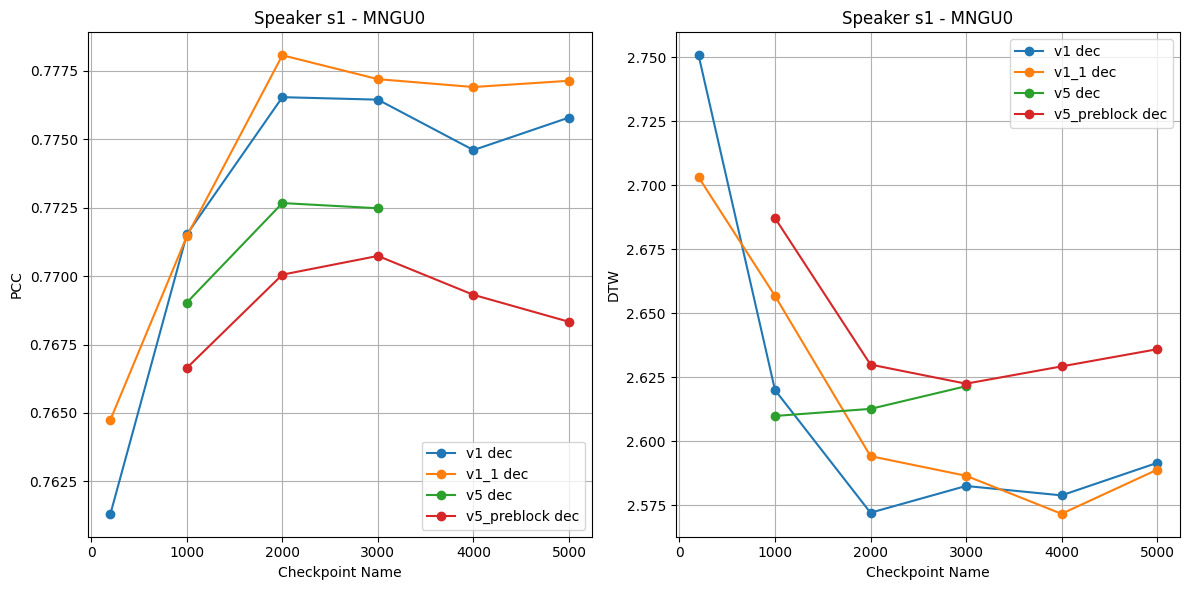

In [7]:
versions = ["v1", "v1_1", "v5", "v5_preblock"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]

for spk in speakers:
    plot_speaker_scores(spk, dataset, versions, dataset_summary, ref="gt")

In [13]:
mngu0_summary = get_specific_summary(dataset, "s1", "v1_1", "grad_2000")
mngu0_summary.sort_values(by="pcc_gt_dec", ascending=True, inplace=True)
worst = mngu0_summary.iloc[0]
best = mngu0_summary.iloc[-1]

In [14]:
mngu0_summary

filestem       pcc  duration  pcc_no_dtw  dtw_gt_enc  dtw_gt_dec  \
1295   mngu0_s1_0562  0.667281     1.985    0.667281    3.793783    3.952654   
1306  mngu0_s1_0898b  0.554526     1.175    0.554526    3.675858    3.597478   
1272  mngu0_s1_0779a  0.718513     1.465    0.718513    4.617867    4.354101   
1309   mngu0_s1_1189  0.544475     0.995    0.544475    3.274074    3.530118   
1298  mngu0_s1_0083a  0.650503     1.380    0.650503    3.809970    3.725579   
...              ...       ...       ...         ...         ...         ...   
81     mngu0_s1_0960  0.911356     3.235    0.911356    1.948631    1.973486   
469   mngu0_s1_0794a  0.884288     2.590    0.884288    2.176535    2.180421   
929   mngu0_s1_0539a  0.841710     1.490    0.841710    2.169299    2.022539   
492    mngu0_s1_0908  0.882918     2.725    0.882918    1.978256    2.043823   
523   mngu0_s1_0898a  0.880604     1.870    0.880604    2.292629    1.961919   

      dtw_gt_sparc  dtw_sparc_enc  dtw_sparc_dec  pcc_gt_enc  pcc_gt_dec  \
1295      2.747793       2.344632       2.451133    0.304073    0.244602   
1306      2.972517       2.485054       2.854621    0.139572    0.274424   
1272      2.416056       3.642892       3.382917    0.174767    0.284969   
1309      2.862297       2.033858       2.672308    0.481525    0.339566   
1298      2.741257       2.657434       3.219838    0.380828    0.357807   
...            ...            ...            ...         ...         ...   
81        1.546826       1.918879       1.715567    0.871874    0.885349   
469       1.689988       2.059637       1.964124    0.865873    0.888349   
929       1.844460       2.049933       1.681049    0.865411    0.889051   
492       1.570213       1.920210       1.835412    0.879177    0.890818   
523       1.636851       2.320658       1.926914    0.880467    0.910874   

      pcc_gt_sparc  pcc_sparc_enc  pcc_sparc_dec  pred_rel_gap  \
1295      0.675203       0.625269       0.655748      0.450000   
1306      0.561306       0.314582       0.260038      0.576271   
1272      0.729478       0.382991       0.485535      0.594595   
1309      0.556710       0.468892       0.289446      0.520000   
1298      0.652223       0.463173       0.331338      0.246377   
...            ...            ...            ...           ...   
81        0.923937       0.884721       0.914634      0.030864   
469       0.898442       0.873833       0.893304      0.084615   
929       0.882345       0.854537       0.901287      0.173333   
492       0.906901       0.887182       0.905154      0.189781   
523       0.902270       0.843503       0.901154      0.202128   

      enc_dtw_distortion  dec_dtw_distortion  sparc_dtw_distortion  
1295            1.036364            0.818182              0.020202  
1306            1.360000            1.360000              0.017241  
1272            0.135593            0.211864              0.027397  
1309            1.083333            1.083333              0.061224  
1298            0.461538            0.576923              0.014706  
...                  ...                 ...                   ...  
81              0.235669            0.235669              0.055901  
469             0.252101            0.285714              0.077519  
929             0.419355            0.451613              0.094595  
492             0.423423            0.414414              0.110294  
523             0.493333            0.493333              0.064516  

[1312 rows x 18 columns]

In [69]:
mngu0_summary[["pcc_gt_dec", "pcc_sparc_dec"]].mean()

pcc_gt_dec       0.778065
pcc_sparc_dec    0.824394
dtype: float64

In [16]:
mngu0_summary["pcc"].mean(), mngu0_summary["pcc"].std()

(np.float64(0.854605064477499), np.float64(0.05692489290881377))

In [25]:
for col in mngu0_summary.columns:
    if col != "filestem":
        correlation, _ = pearsonr(mngu0_summary["pcc_gt_dec"], mngu0_summary[col])
        print(f"Correlation between pcc_gt_dec and {col}: {correlation:.4f}")

Correlation between pcc_gt_dec and pcc: 0.6334
Correlation between pcc_gt_dec and duration: 0.3266
Correlation between pcc_gt_dec and pcc_no_dtw: 0.6334
Correlation between pcc_gt_dec and dtw_gt_enc: -0.8439
Correlation between pcc_gt_dec and dtw_gt_dec: -0.8529
Correlation between pcc_gt_dec and dtw_gt_sparc: -0.6118
Correlation between pcc_gt_dec and dtw_sparc_enc: -0.3547
Correlation between pcc_gt_dec and dtw_sparc_dec: -0.3200
Correlation between pcc_gt_dec and pcc_gt_enc: 0.9324
Correlation between pcc_gt_dec and pcc_gt_dec: 1.0000
Correlation between pcc_gt_dec and pcc_gt_sparc: 0.6547
Correlation between pcc_gt_dec and pcc_sparc_enc: 0.7601
Correlation between pcc_gt_dec and pcc_sparc_dec: 0.8020
Correlation between pcc_gt_dec and pred_rel_gap: -0.4632
Correlation between pcc_gt_dec and enc_dtw_distortion: -0.4773
Correlation between pcc_gt_dec and dec_dtw_distortion: -0.4734
Correlation between pcc_gt_dec and sparc_dtw_distortion: -0.0186


In [26]:
dataset = "MNGU0"
speaker = "s1"
src_data_dir = DATA_DIR / dataset / "src_data" / speaker / "ema_basic_data"
emasrc_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "emasrc"
spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
reconstructed_dir = DATA_DIR / dataset / "arttts" / speaker / "hifigan_pred"

/tmp/ipykernel_124714/4157905919.py:14: RuntimeWarning: invalid value encountered in divide
  ema_data_14 = (ema_data_14 - ema_data_14.mean(axis=0)) / ema_data_14.std(axis=0)


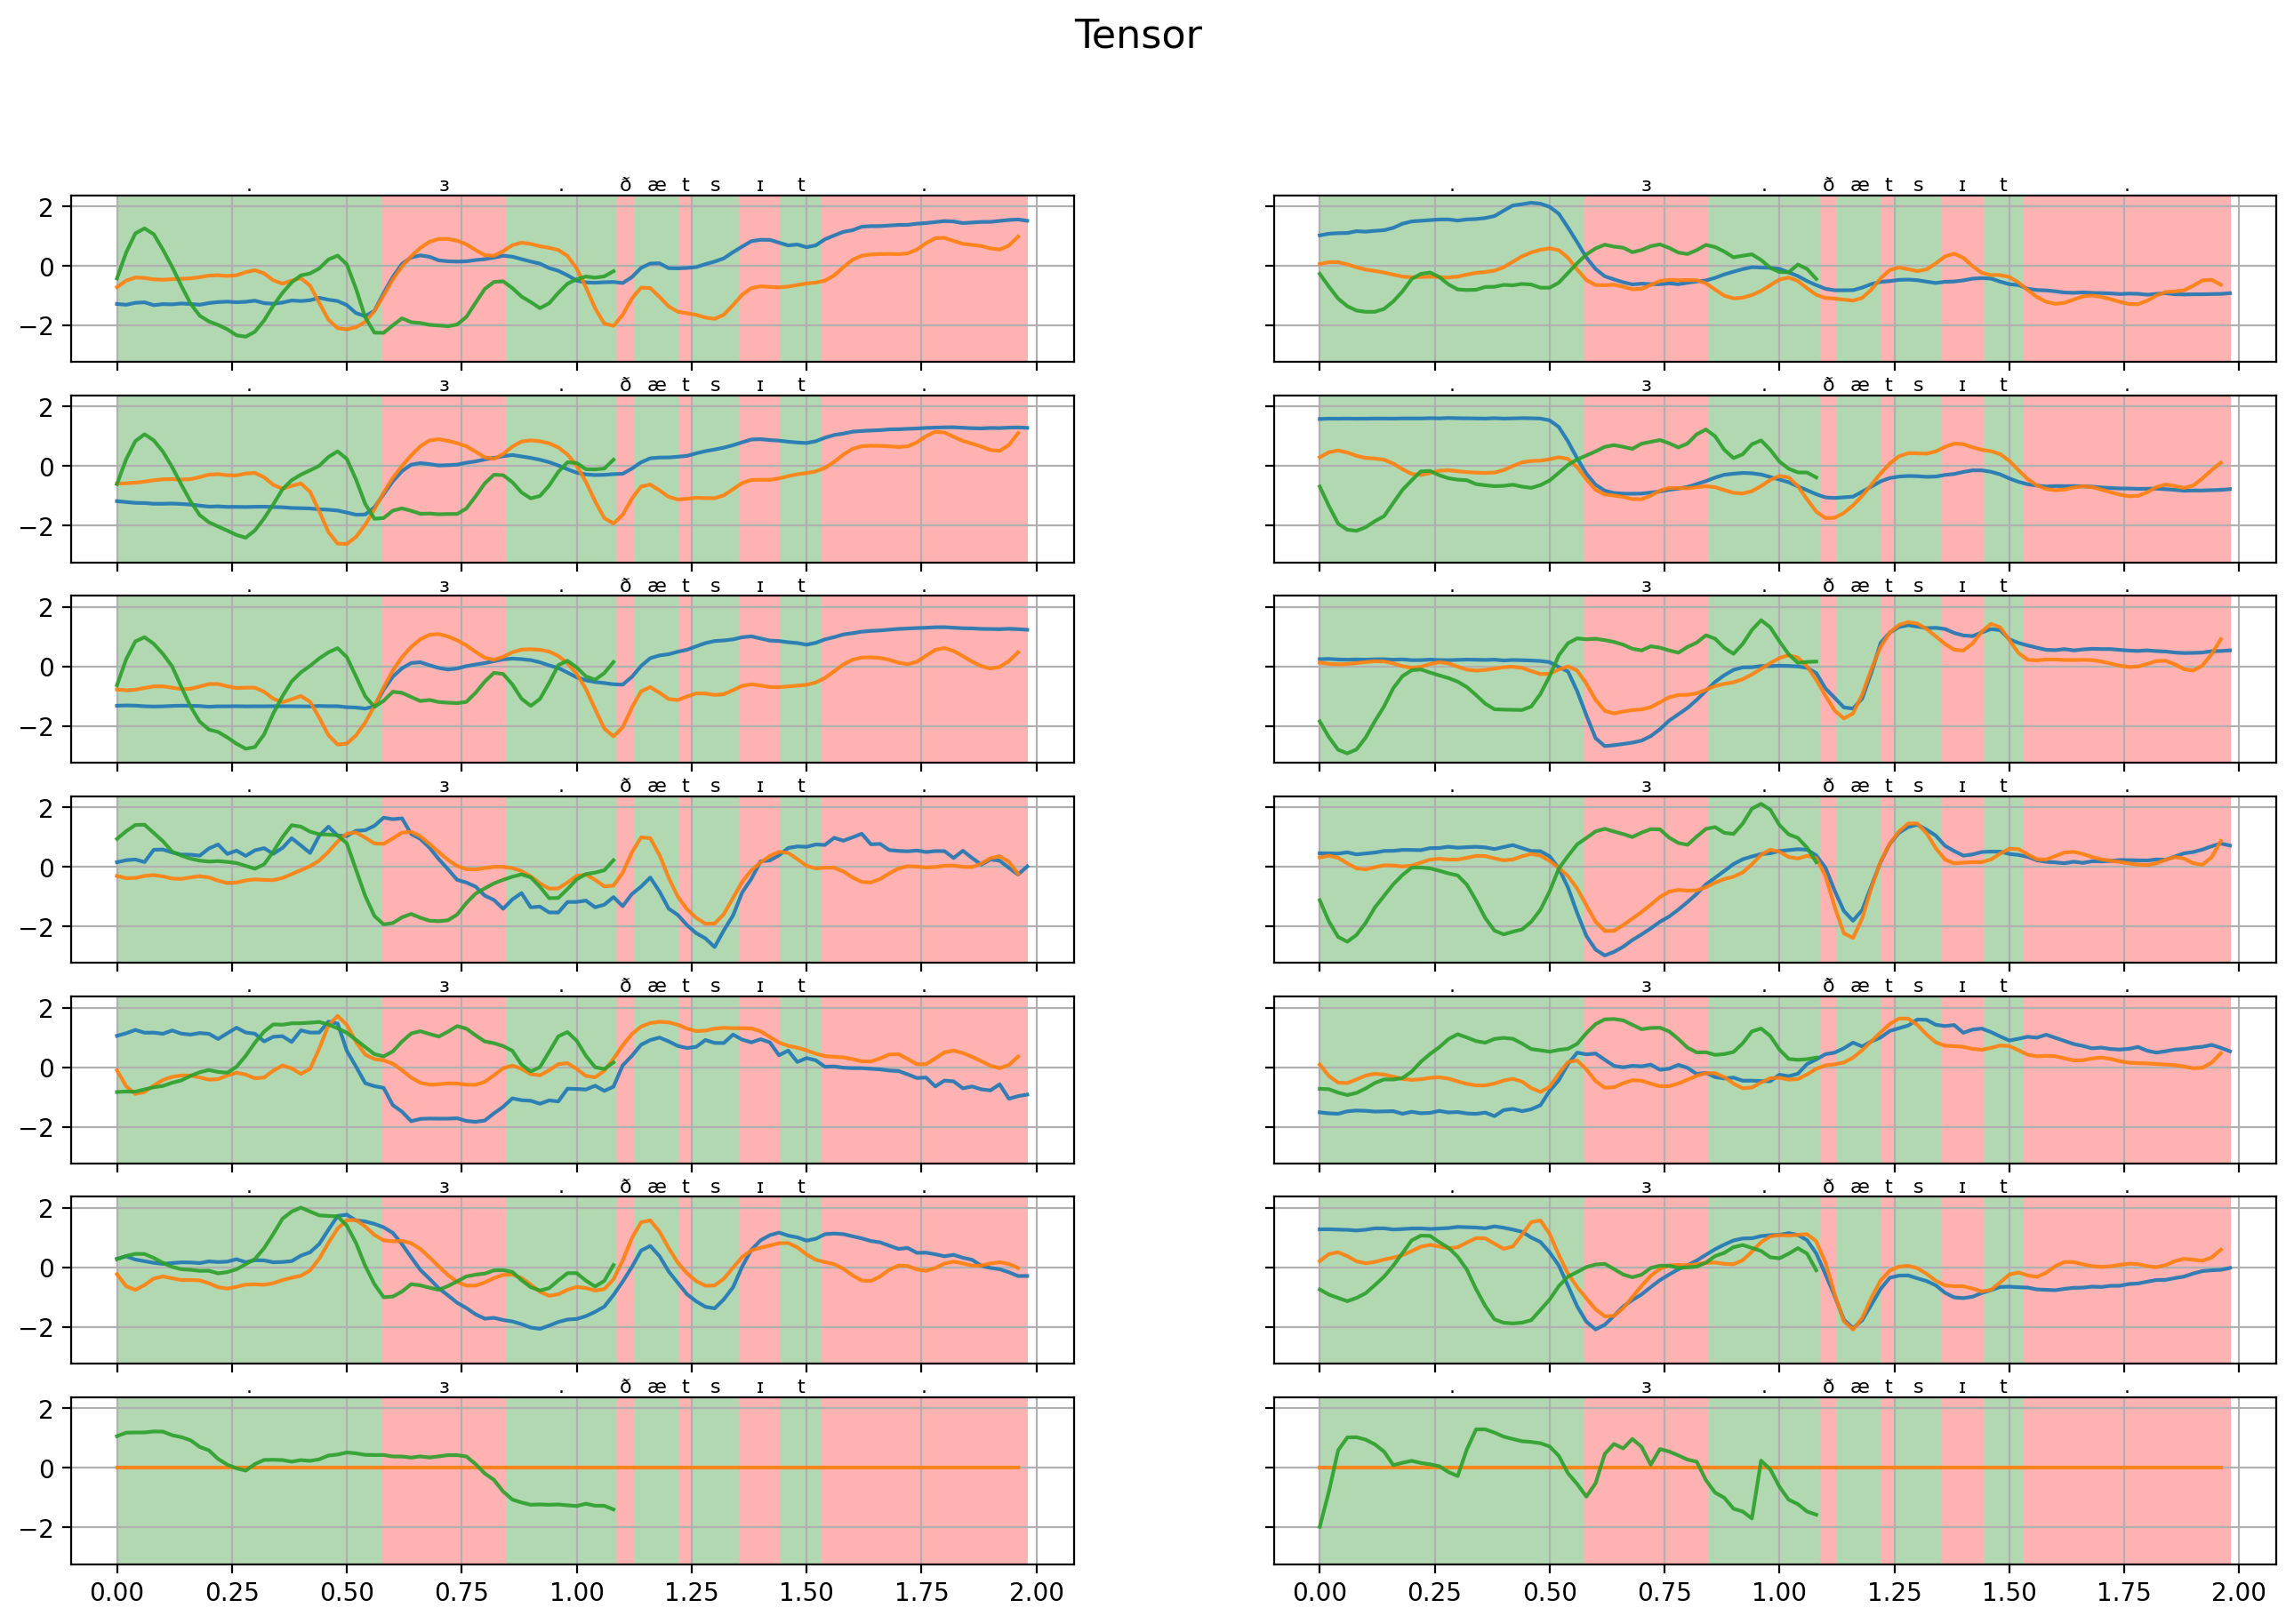

In [27]:
from utils_dataset.mngu0 import read_mngu0_ema, MNGU0_features
from utils import plot_art_14

sample_id = worst["filestem"]
arttts_dir = DATA_DIR / dataset / "arttts" / speaker / "arttts_pred" / "v1_1" / "grad_2000"
art_ema = np.load(arttts_dir / f"{sample_id}.npy")
art_ema_14 = art_ema[14:28,:].T
art_ema_align = art_ema[28]
raw_ema_fp = src_data_dir/ f"{sample_id}.ema"
ema_data, nonan = read_mngu0_ema(raw_ema_fp)
sparc_ema = np.load(emasrc_dir / f"{sample_id}.npy")[:,:12]
phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
ema_data_14 = np.pad(ema_data, ((0, 0), (0, 2)), mode='constant', constant_values=0)
ema_data_14 = (ema_data_14 - ema_data_14.mean(axis=0)) / ema_data_14.std(axis=0)
ema_data_14 = ema_data_14[::4,:]
sparc_ema_14 = np.pad(sparc_ema, ((0, 0), (0, 2)), mode='constant', constant_values=0)


fig, _ = plot_art_14([ema_data_14.T,
                      sparc_ema_14.T,
                        art_ema_14.T,
                      ],
                       phnm3=phnm3,
                       figsize=(16, 10),)
fig

/tmp/ipykernel_124714/4041848580.py:12: RuntimeWarning: invalid value encountered in divide
  ema_data_14 = (ema_data_14 - ema_data_14.mean(axis=0)) / ema_data_14.std(axis=0)


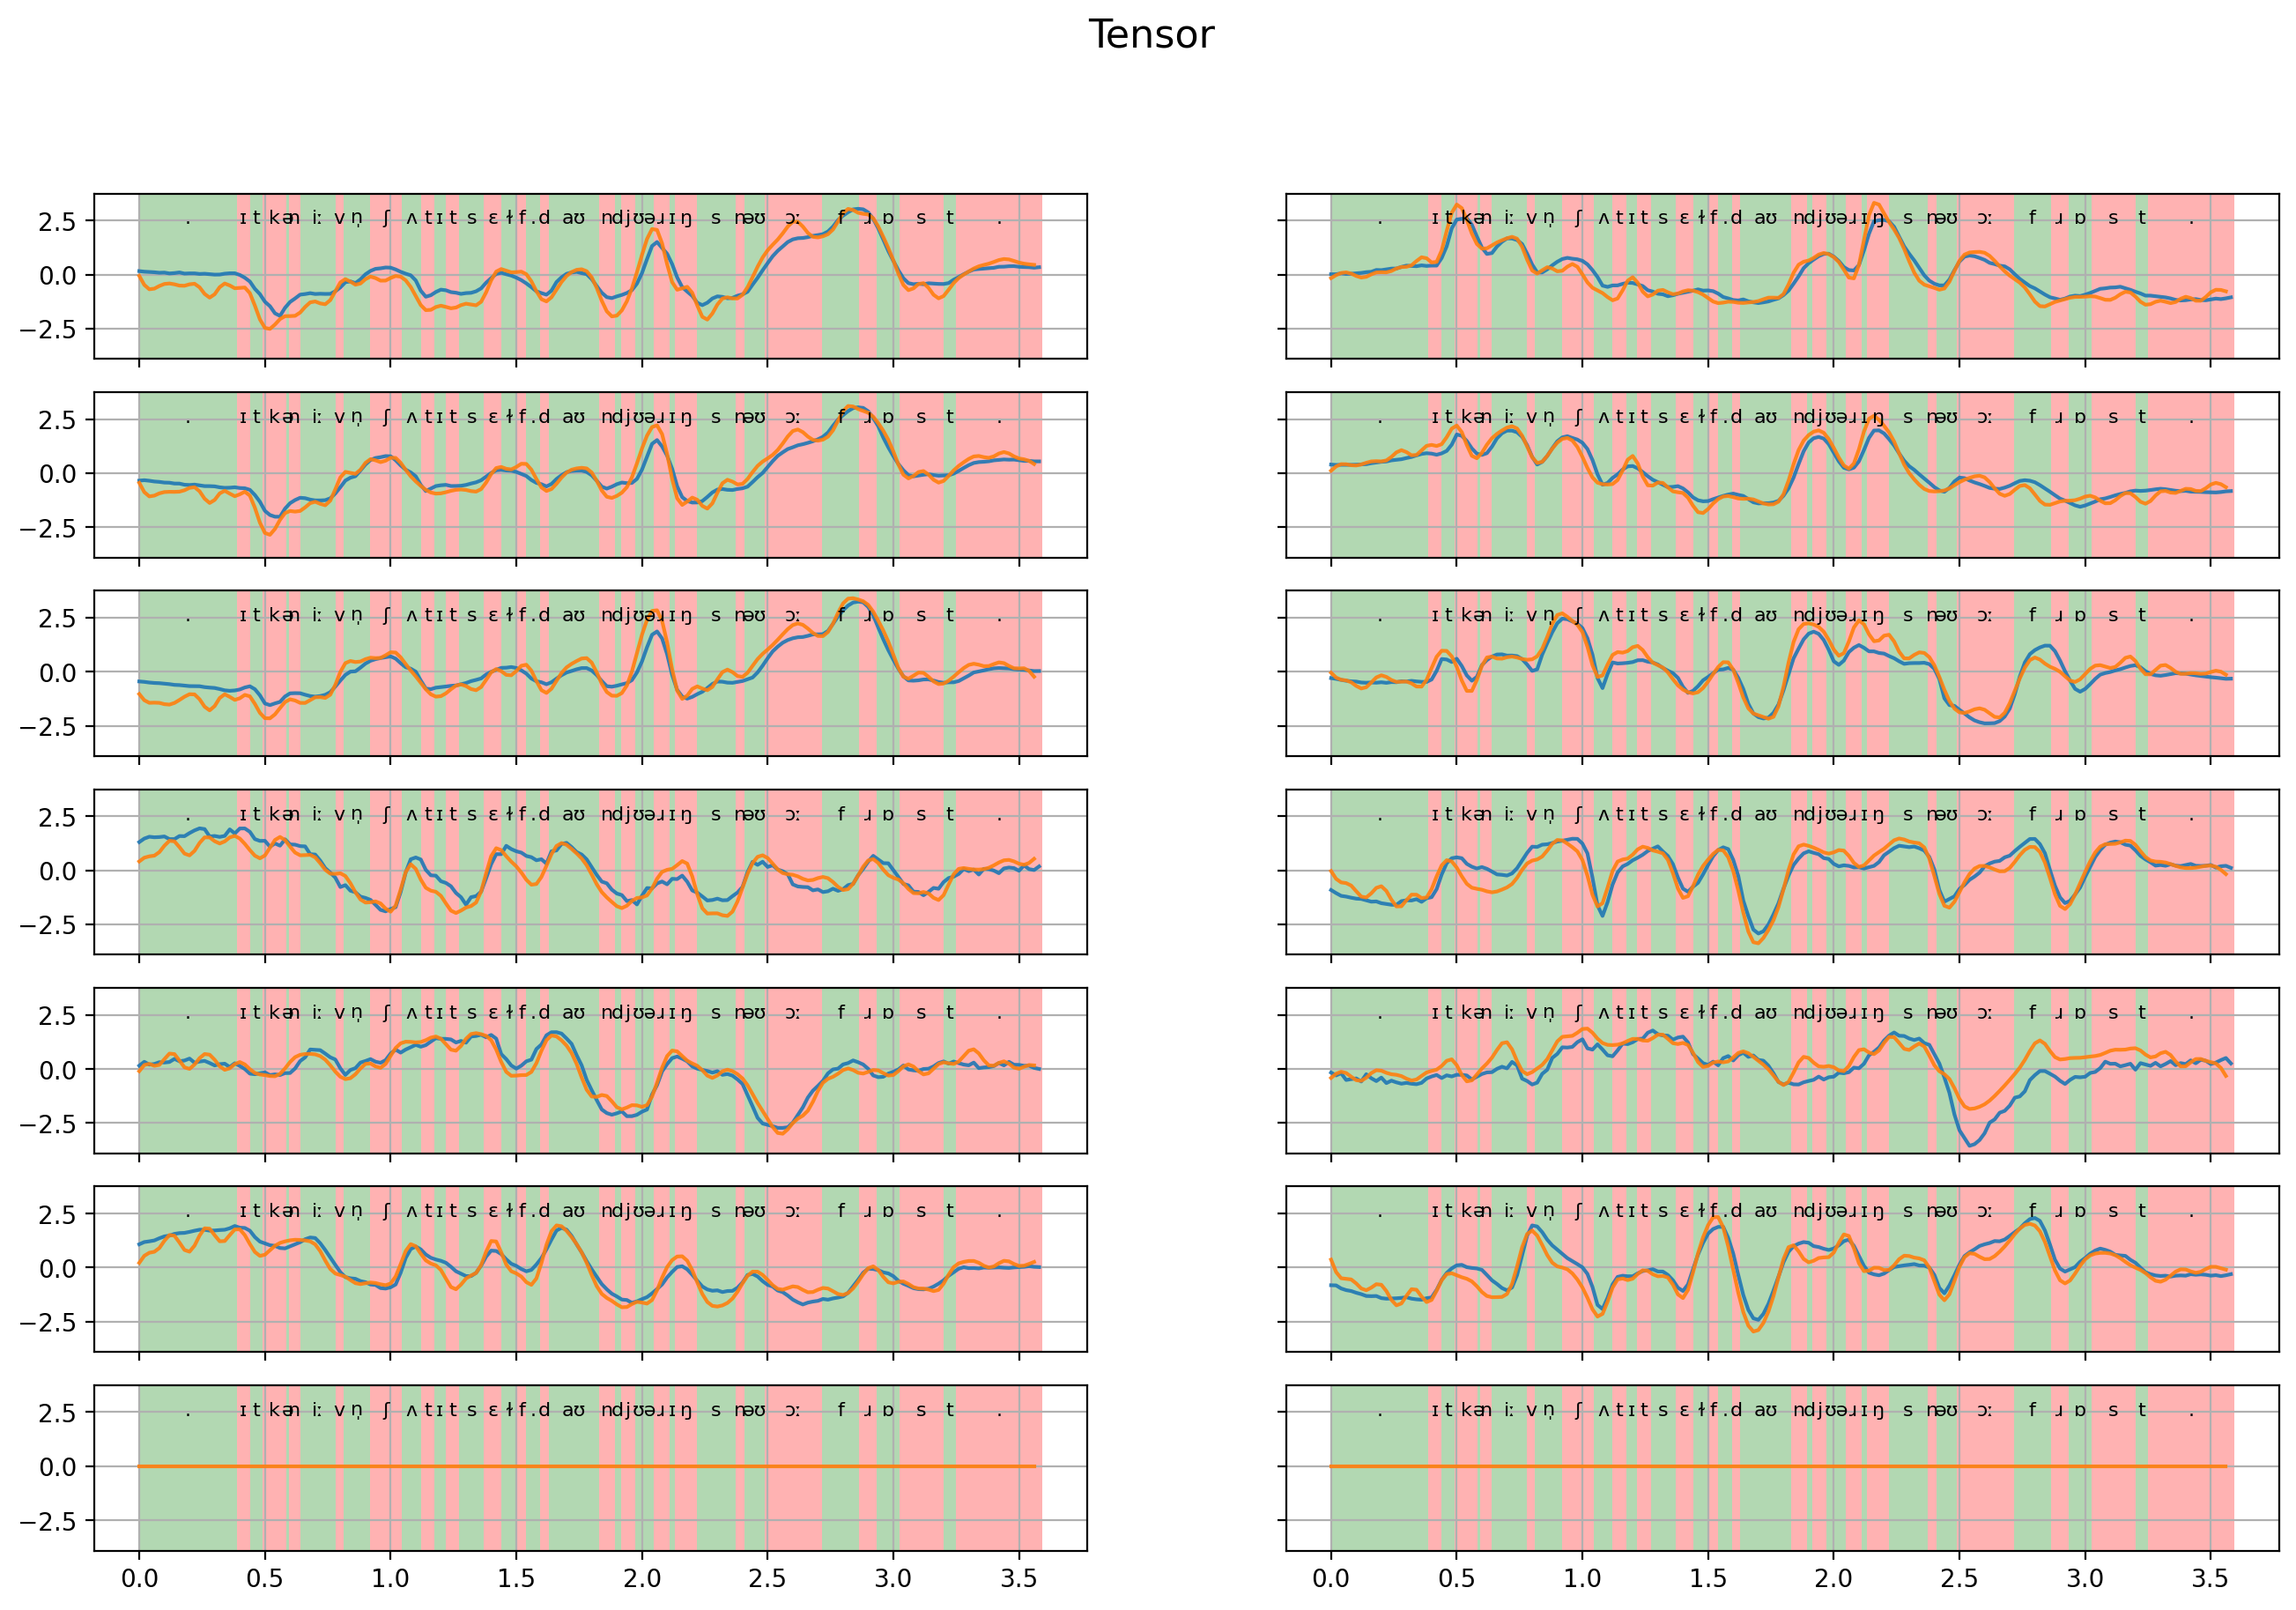

In [28]:
from utils_dataset.mngu0 import read_mngu0_ema, MNGU0_features
from utils import plot_art_14

raw_ema_fp = list(src_data_dir.glob("*"))[522]
raw_ema_fp = raw_ema_fp.parent / f"mngu0_s1_1215.ema"
sample_id = raw_ema_fp.stem
ema_data, nonan = read_mngu0_ema(raw_ema_fp)
sparc_ema = np.load(emasrc_dir / f"{sample_id}.npy")[:,:12]
phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")

ema_data_14 = np.pad(ema_data, ((0, 0), (0, 2)), mode='constant', constant_values=0)
ema_data_14 = (ema_data_14 - ema_data_14.mean(axis=0)) / ema_data_14.std(axis=0)
ema_data_14 = ema_data_14[::4,:]
sparc_ema_14 = np.pad(sparc_ema, ((0, 0), (0, 2)), mode='constant', constant_values=0)

fig, _ = plot_art_14([ema_data_14.T,
                       sparc_ema_14.T],
                       phnm3=phnm3,
                       figsize=(16, 10),)
fig

# Versions comparison

In [5]:
for k, v in dataset_2_extra_ipa.items():
    print(f"{k} has {len(v)} extra IPA phonemes not present in LJ Speech")
    print()

MSPKA_EMA_ita has 27 extra IPA phonemes not present in LJ Speech

pb2007 has 12 extra IPA phonemes not present in LJ Speech

MNGU0 has 17 extra IPA phonemes not present in LJ Speech

mocha_timit has 9 extra IPA phonemes not present in LJ Speech



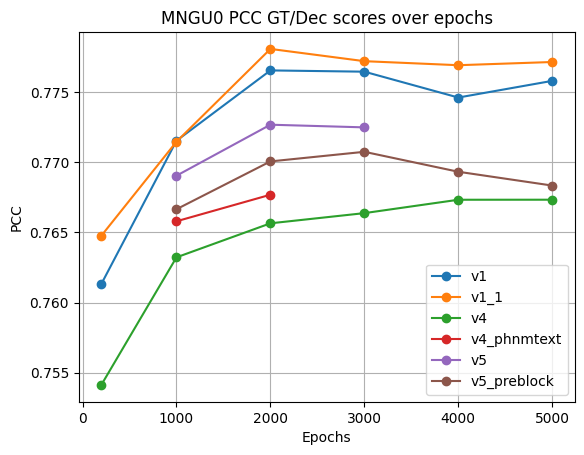

In [ ]:
dataset = "MNGU0"
speakers = ["s1"]
versions = ["v1", "v1_1", "v4", "v4_phnmtext", "v5", "v5_preblock"]
truc = create_dataset_summary(dataset, speakers, versions)

for version in versions:
    plt.plot(truc[truc["version"] == version]["epoch"], truc[truc["version"] == version]["pcc_gt_dec"], marker="o", label=version)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("PCC")
plt.title(f"{dataset} PCC GT/Dec scores over epochs")
plt.grid()
# v4_phnmtext far from being the best, lot of out of vocab phonemes in MNGU0
# but v4_phnmtext performs better than v4, probably because v4 use letter embeddings as well
# which can be more ambiguous than phonemes on in vocabulary cases.


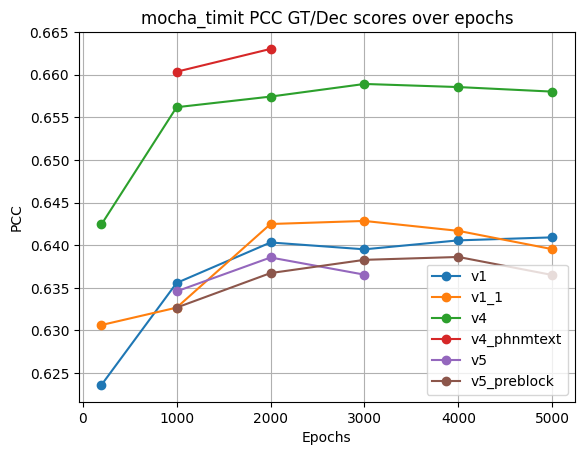

In [23]:
dataset = "mocha_timit"
speakers = ["faet0", "fsew0", "ffes0", "maps0", "msak0", "mjjn0"]
versions = ["v1", "v1_1", "v4", "v4_phnmtext", "v5", "v5_preblock"]
truc = create_dataset_summary(dataset, speakers, versions)
truc = truc.groupby(["version", "epoch"]).mean("pcc_gt_dec").reset_index()

for version in versions:
    plt.plot(truc[truc["version"] == version]["epoch"], truc[truc["version"] == version]["pcc_gt_dec"], marker="o", label=version)
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("PCC")
plt.title(f"{dataset} PCC GT/Dec scores over epochs")
plt.grid()
# v4_phnmtext better, indeed mocha has fewer out of vocabulary phonemes compared to mngu0 (6 vs 17)
# v4 performs better as well, here the generalization advantage of the other versions is useless
# since the phnm vocabularies overlap a lot. The learnt embeeddings of v4s allow more powerful representations

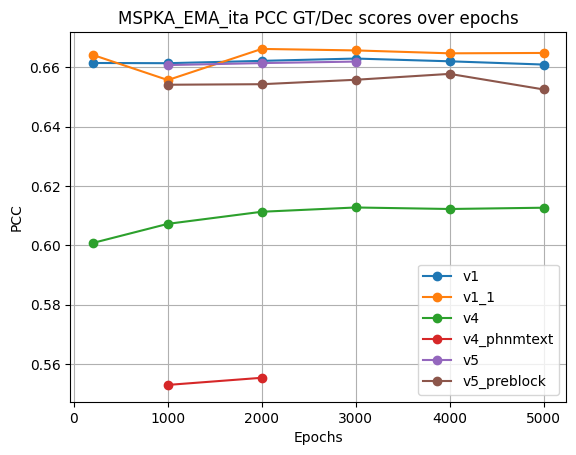

In [24]:
dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "olm"]
versions = ["v1", "v1_1", "v4", "v4_phnmtext", "v5", "v5_preblock"]
truc = create_dataset_summary(dataset, speakers, versions)
truc = truc.groupby(["version", "epoch"]).mean("pcc_gt_dec").reset_index()

for version in versions:
    plt.plot(truc[truc["version"] == version]["epoch"], truc[truc["version"] == version]["pcc_gt_dec"], marker="o", label=version)
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("PCC")
plt.title(f"{dataset} PCC GT/Dec scores over epochs")
plt.grid()
# v4_phnmtext performs very poorly, expected since mspka has a lot of out of vocabulary phnms (italian)
# v4 performs poorly as well compared to the other versions because the latter use phnm ternary features
# and are expected to perform better generalization on unseen phonemes
# However v4 performs better than v4_phnmtext, because v4 use letter embeddings as well and some letters are cross-lingual

In [25]:
truc

version  epoch  pcc_no_dtw  dtw_gt_enc  dtw_gt_dec  dtw_gt_sparc  \
0            v1    200    0.762753    2.544092    2.492535      2.069043   
1            v1   1000    0.762753    2.562462    2.482087      2.069043   
2            v1   2000    0.762753    2.552356    2.470332      2.069043   
3            v1   3000    0.762753    2.541851    2.469894      2.069043   
4            v1   4000    0.762753    2.549480    2.469172      2.069043   
5            v1   5000    0.762753    2.555914    2.473889      2.069043   
6          v1_1    200    0.762753    2.515020    2.476150      2.069043   
7          v1_1   1000    0.762753    2.542601    2.493399      2.069043   
8          v1_1   2000    0.762753    2.540997    2.463519      2.069043   
9          v1_1   3000    0.762753    2.540439    2.463285      2.069043   
10         v1_1   4000    0.762753    2.544521    2.466034      2.069043   
11         v1_1   5000    0.762753    2.534613    2.464501      2.069043   
12           v4    200    0.762753    2.643849    2.619373      2.069043   
13           v4   1000    0.762753    2.640097    2.599720      2.069043   
14           v4   2000    0.762753    2.636182    2.587475      2.069043   
15           v4   3000    0.762753    2.632549    2.588213      2.069043   
16           v4   4000    0.762753    2.631559    2.587042      2.069043   
17           v4   5000    0.762753    2.635359    2.587835      2.069043   
18  v4_phnmtext   1000    0.762753    2.802491    2.748789      2.069043   
19  v4_phnmtext   2000    0.762753    2.802194    2.740425      2.069043   
20           v5   1000    0.762753    2.525755    2.480234      2.069043   
21           v5   2000    0.762753    2.551085    2.474722      2.069043   
22           v5   3000    0.762753    2.541285    2.470677      2.069043   
23  v5_preblock   1000    0.762753    2.627241    2.511328      2.069043   
24  v5_preblock   2000    0.762653    2.617281    2.506493      2.069549   
25  v5_preblock   3000    0.762719    2.623208    2.503538      2.068959   
26  v5_preblock   4000    0.762747    2.615378    2.497164      2.069128   
27  v5_preblock   5000    0.762656    2.606500    2.501137      2.069235   

    dtw_sparc_enc  dtw_sparc_dec  pcc_gt_enc  pcc_gt_dec  pcc_gt_sparc  \
0        1.716595       1.683927    0.648081    0.661443      0.793625   
1        1.743800       1.674972    0.638958    0.661372      0.793625   
2        1.733714       1.662610    0.639615    0.662160      0.793625   
3        1.730723       1.666158    0.643337    0.662938      0.793625   
4        1.745247       1.671678    0.639891    0.662015      0.793625   
5        1.750432       1.675081    0.638905    0.660915      0.793625   
6        1.695657       1.674426    0.654800    0.664182      0.793625   
7        1.736688       1.685692    0.643458    0.655690      0.793625   
8        1.730211       1.667622    0.643924    0.666185      0.793625   
9        1.734178       1.667368    0.644224    0.665680      0.793625   
10       1.738990       1.670171    0.642098    0.664703      0.793625   
11       1.735216       1.668156    0.645125    0.664826      0.793625   
12       1.858684       1.846183    0.594666    0.600758      0.793625   
13       1.860554       1.832319    0.595682    0.607222      0.793625   
14       1.860089       1.827146    0.597169    0.611294      0.793625   
15       1.858219       1.825469    0.599628    0.612734      0.793625   
16       1.862084       1.826528    0.599222    0.612227      0.793625   
17       1.860920       1.827092    0.597324    0.612655      0.793625   
18       2.038530       1.996702    0.533861    0.552919      0.793625   
19       2.037729       1.988657    0.534200    0.555325      0.793625   
20       1.724043       1.679839    0.649991    0.660735      0.793625   
21       1.750401       1.679957    0.640688    0.661408      0.793625   
22       1.746134       1.679981    0.642399    0.661916      0.793625   
23       1.790816       1.6

In [15]:
datasets = ["mocha_timit", "MNGU0", "MSPKA_EMA_ita"]
dataset_2_speakers = {
        "MSPKA_EMA_ita": ["cnz", "olm"],
        "pb2007": ["spk1"],
        "mocha_timit": ["faet0", "ffes0", "fsew0", "maps0", "mjjn0", "msak0"],
        "MNGU0": ["s1"],
    }
ckpt_name = "grad_2000"

data = []
for i in range(len(datasets)):
    dataset = datasets[i]
    for version in ["v1", "v1_1", "v4", "v4_phnmtext"]:
        version_df = pd.concat([get_specific_summary(dataset, speaker, version, ckpt_name) for speaker in dataset_2_speakers[dataset]])
        row = {
            "dataset": dataset,
            "version": version,
            "ckpt_name": ckpt_name,
            "pcc_gt_dec_mean": version_df["pcc_gt_dec"].mean(),
            "pcc_gt_dec_std": version_df["pcc_gt_dec"].std(),
        }
        data.append(row)
data = pd.DataFrame(data)

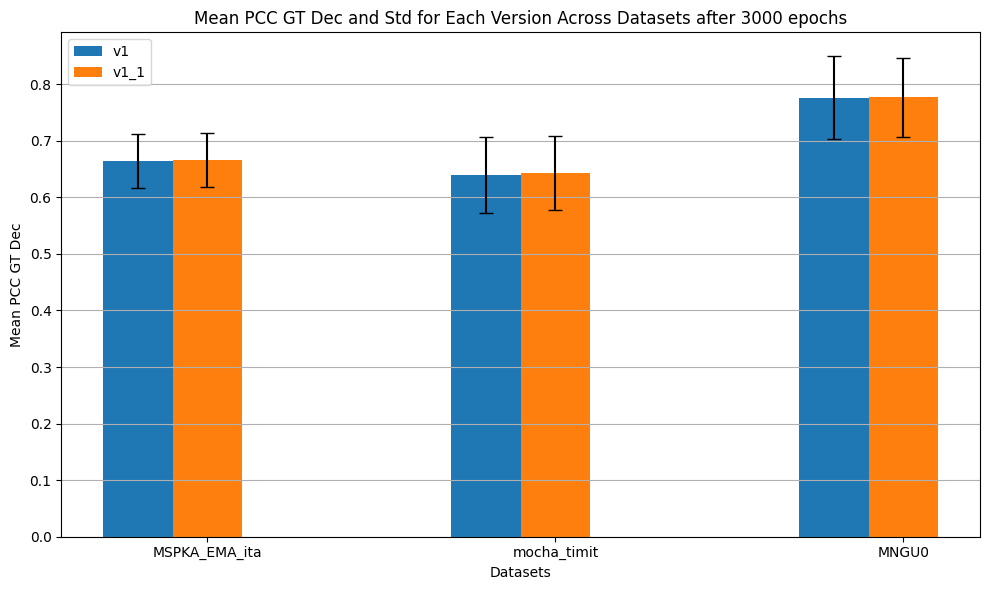

In [16]:
datasets = ["MSPKA_EMA_ita", "mocha_timit", "MNGU0"]
versions = ["v1", "v1_1"]#, "v4", "v4_phnmtext"]
width = 0.2  # Bar width
x = np.arange(len(datasets))  # Dataset positions
n_epochs = 3000

# Prepare data for plotting
mean_scores = []
std_scores = []

for version in versions:
    means = []
    stds = []
    for dataset in datasets:
        version_df = pd.concat([get_specific_summary(dataset, speaker, version, f"grad_{n_epochs}") for speaker in dataset_2_speakers[dataset]])
        means.append(version_df["pcc_gt_dec"].mean())
        stds.append(version_df["pcc_gt_dec"].std())
    mean_scores.append(means)
    std_scores.append(stds)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, version in enumerate(versions):
    ax.bar(x + i * width, mean_scores[i], width, yerr=std_scores[i], label=version, capsize=5)

# Add labels and legend
ax.set_xlabel("Datasets")
ax.set_ylabel("Mean PCC GT Dec")
ax.set_title(f"Mean PCC GT Dec and Std for Each Version Across Datasets after {n_epochs} epochs")
ax.set_xticks(x + width)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis="y")

plt.tight_layout()
plt.show()

In [35]:
datasets = ["MSPKA_EMA_ita", "mocha_timit", "MNGU0"]
version = "v1_1"
cols = ["pcc_gt_dec", "pcc_sparc_dec"]
width = 0.2  # Bar width
x = np.arange(len(datasets))  # Dataset positions

# Prepare data for plotting
mean_scores = {k : [] for k in cols}
std_scores = {k}
means = []
stds = []
for dataset in datasets:
    version_df = pd.concat([get_specific_summary(dataset, speaker, version, "grad_2000") for speaker in dataset_2_speakers[dataset]])
    for col in cols:
        means.append(version_df[col].mean())
        stds.append(version_df[col].std())
mean_scores.append(means)
std_scores.append(stds)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, col in enumerate(cols):
    ax.bar(x + i * width, mean_scores[i], width, yerr=std_scores[i], label=version, capsize=5)

# Add labels and legend
ax.set_xlabel("Datasets")
ax.set_ylabel("Mean PCC GT Dec")
ax.set_title("Mean PCC GT Dec and Std for Each Version Across Datasets after 2000 epochs")
ax.set_xticks(x + width)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis="y")

plt.tight_layout()
plt.show()

AttributeError: 'dict' object has no attribute 'append'

# Phoneme level analysis

In [ ]:
from text.phnms import get_phnms_from_phnm3
from text.converters import arpabet2ipa

lj_ipa_set = set(arpabet2ipa.values())

version = "v1_1"
ckpt_name = "grad_3000"

## MSPKA_EMA_ita

In [ ]:
from utils_dataset.mspka import mspka2ipa

mspka_ipa_set = set(mspka2ipa.values())
extra_ipa_set = mspka_ipa_set - lj_ipa_set

dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "olm", "lls"]

In [ ]:
phnms_stats = {}

speaker = "cnz"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
cnz_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in cnz_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "lls"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
lls_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in lls_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "olm"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
olm_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in olm_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

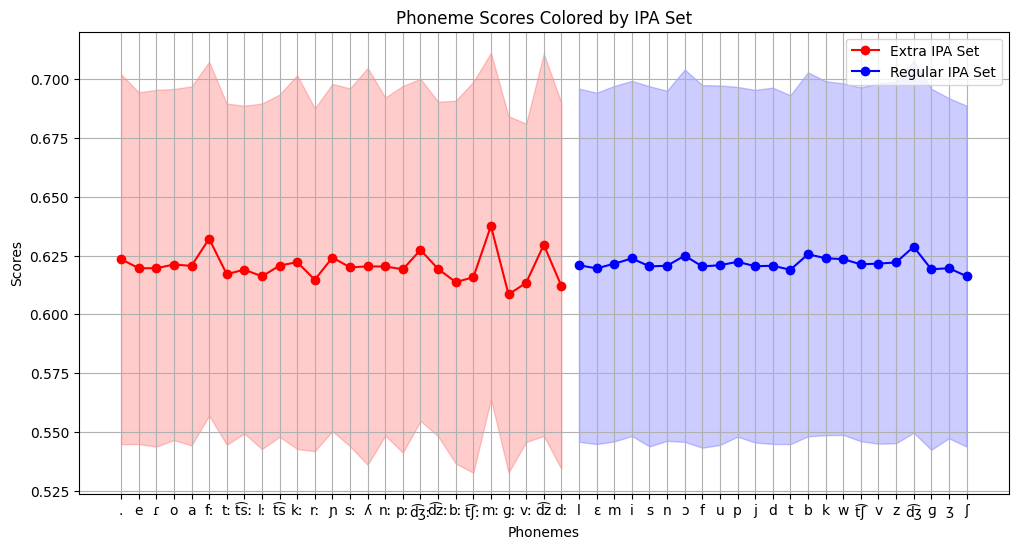

In [ ]:
# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

## pb2007

In [ ]:
from utils_dataset.pb2007 import pb20072ipa

pb2007_ipa_set = set(pb20072ipa.values())
extra_ipa_set = pb2007_ipa_set - lj_ipa_set

dataset = "pb2007"
speakers = ["spk1"]

In [ ]:
phnms_stats = {}

speaker = "spk1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
spk1_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in spk1_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])
        
phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

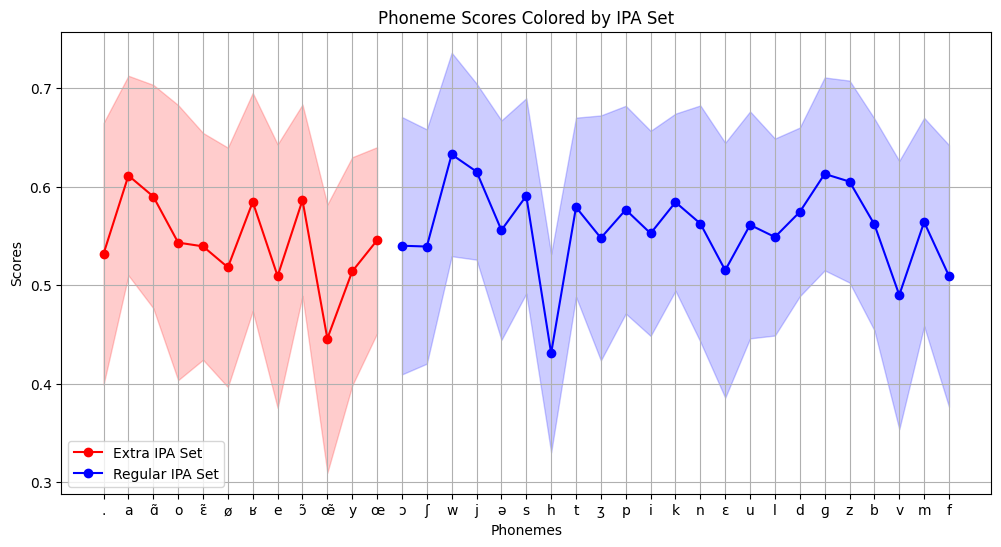

In [ ]:
# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

## MNGU0

In [ ]:
from utils_dataset.mngu0 import mngu02ipa

mngu0_ipa_set = set(mngu02ipa.values())
extra_ipa_set = mngu0_ipa_set - lj_ipa_set

dataset = "MNGU0"
speakers = ["spk1"]

In [ ]:
phnms_stats = {}

speaker = "s1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
s1_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in s1_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])
        
phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

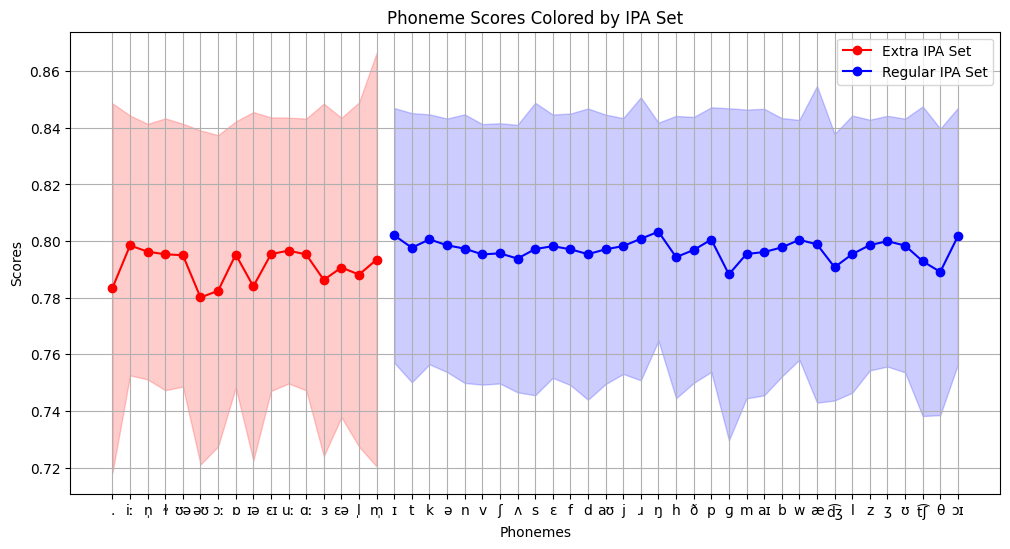

In [ ]:
# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

## mocha_timit

In [ ]:
dataset = "mocha_timit"
speakers = ["fsew0", "faet0", "ffes0", "maps0", "mjjn0", "msak0"]

In [ ]:
phnms_stats = {}

speaker = "fsew0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
fsew0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in fsew0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "faet0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
faet0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in faet0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "ffes0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
ffes0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in ffes0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "maps0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
maps0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in maps0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "mjjn0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
mjjn0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in mjjn0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "msak0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
msak0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in msak0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])
        
phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

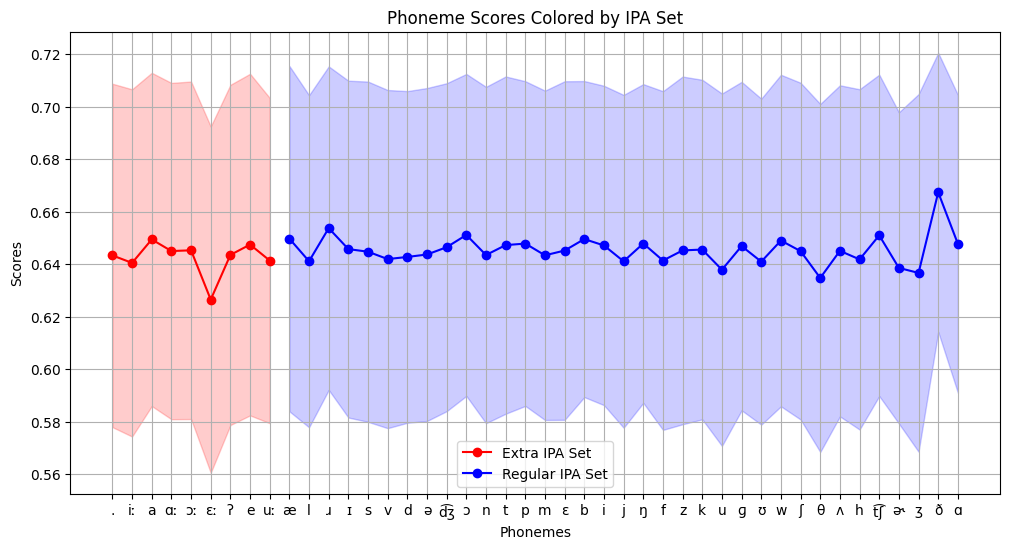

In [ ]:
mocha_ipa_set = set(phnms_scores.keys())
extra_ipa_set = mocha_ipa_set - lj_ipa_set

# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

# Pitch sensitivity

# Spk_emb sensitivity

## build mean spk_embs

In [ ]:
dataset = "MNGU0"
speaker = "s1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
s1_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"

fp_list = list(spk_emb_dir.glob("*.npy"))
spk_embs = np.zeros((len(fp_list), 64), dtype=np.float32)
for i, fp in enumerate(fp_list):
    sample_id = fp.stem
    spk_emb = np.load(fp)
    spk_embs[i, :] = spk_emb
np.save(spk_emb_dir / "mean_spk_emb.npy", spk_embs.mean(axis=0))

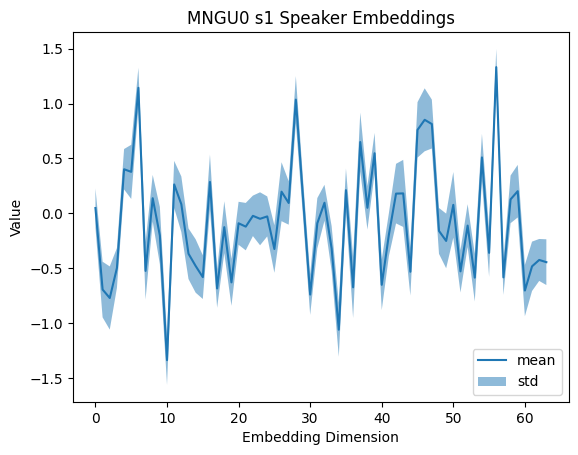

In [ ]:
spk_embs.mean(axis=0), spk_embs.std(axis=0)
plt.plot(spk_embs.mean(axis=0), label="mean")
plt.fill_between(np.arange(64), spk_embs.mean(axis=0) - spk_embs.std(axis=0),
                 spk_embs.mean(axis=0) + spk_embs.std(axis=0), alpha=0.5, label="std")
plt.title(f"{dataset} {speaker} Speaker Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

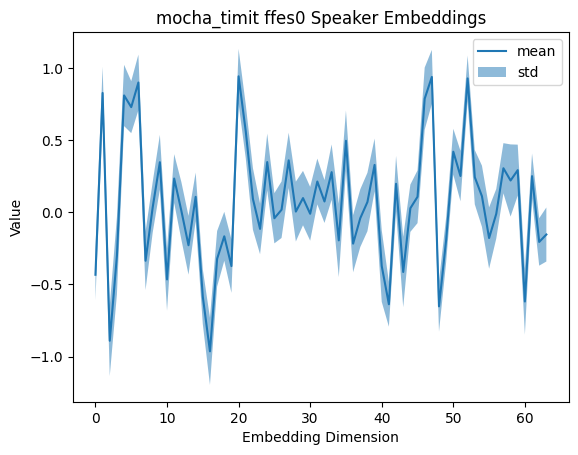

In [ ]:
dataset = "mocha_timit"
speakers = ['fsew0', 'faet0', 'maps0', 'msak0', 'mjjn0', 'ffes0']
speaker = speakers[5]
for speaker in speakers:
    spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"

    fp_list = list(spk_emb_dir.glob("*.npy"))
    spk_embs = np.zeros((len(fp_list), 64), dtype=np.float32)
    for i, fp in enumerate(fp_list):
        sample_id = fp.stem
        spk_emb = np.load(fp)
        spk_embs[i, :] = spk_emb
    np.save(spk_emb_dir / "mean_spk_emb.npy", spk_embs.mean(axis=0))

plt.plot(spk_embs.mean(axis=0), label="mean")
plt.fill_between(np.arange(64), spk_embs.mean(axis=0) - spk_embs.std(axis=0),
                 spk_embs.mean(axis=0) + spk_embs.std(axis=0), alpha=0.5, label="std")
plt.title(f"{dataset} {speaker} Speaker Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

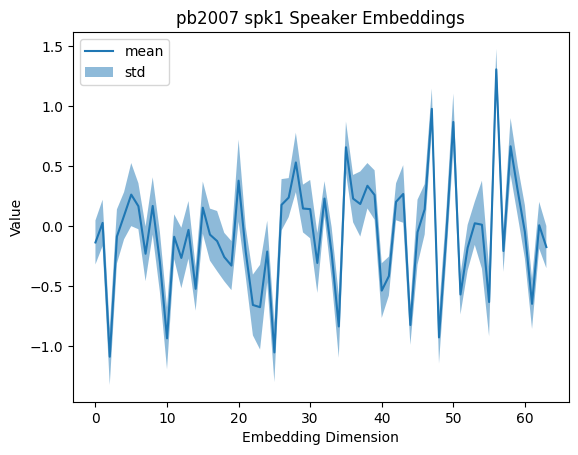

In [ ]:
spk1_sentences_df = spk1_df[spk1_df["sentence_types"] == "sentence"]

dataset = "pb2007"
speaker = "spk1"
spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"

fp_list = list(spk_emb_dir.glob("*.npy"))
#only use sentences spk_emb
fp_list = [spk_emb_dir / f"{filestem}.npy" for filestem in spk1_sentences_df["filestem"]]
spk_embs = np.zeros((len(fp_list), 64), dtype=np.float32)
for i, fp in enumerate(fp_list):
    sample_id = fp.stem
    spk_emb = np.load(fp)
    spk_embs[i, :] = spk_emb
np.save(spk_emb_dir / "mean_spk_emb.npy", spk_embs.mean(axis=0))

plt.plot(spk_embs.mean(axis=0), label="mean")
plt.fill_between(np.arange(64), spk_embs.mean(axis=0) - spk_embs.std(axis=0),
                 spk_embs.mean(axis=0) + spk_embs.std(axis=0), alpha=0.5, label="std")
plt.title(f"{dataset} {speaker} Speaker Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

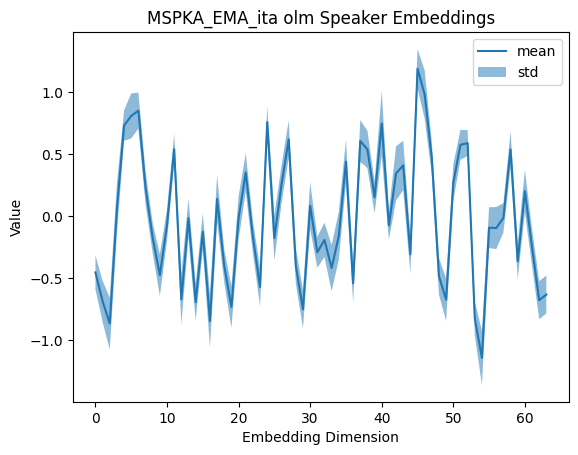

In [ ]:
dataset = "MSPKA_EMA_ita"
speakers = ['cnz', 'lls', 'olm']

for speaker in speakers:
    spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"

    fp_list = list(spk_emb_dir.glob("*.npy"))
    spk_embs = np.zeros((len(fp_list), 64), dtype=np.float32)
    for i, fp in enumerate(fp_list):
        sample_id = fp.stem
        spk_emb = np.load(fp)
        spk_embs[i, :] = spk_emb
    np.save(spk_emb_dir / "mean_spk_emb.npy", spk_embs.mean(axis=0))

plt.plot(spk_embs.mean(axis=0), label="mean")
plt.fill_between(np.arange(64), spk_embs.mean(axis=0) - spk_embs.std(axis=0),
                 spk_embs.mean(axis=0) + spk_embs.std(axis=0), alpha=0.5, label="std")
plt.title(f"{dataset} {speaker} Speaker Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

# Check text embedding (irregular results on italian) shouldn'it be able since not trained on italian words and only trained on english phonemes from cmudict in theory


In [ ]:
dataset = "MSPKA_EMA_ita"
speaker = "lls"

dataset_2_spkmetadata = {
        "MSPKA_EMA_ita": "mixed_speaker_metadata_100Hz.joblib",
        "pb2007": "1.0_speaker_metadata_100Hz.joblib",
        "mocha_timit": "mixed_speaker_metadata_100Hz.joblib",
    }

processed_data_dir = DATA_DIR / dataset / "processed_data"
spkmetadata_filename = dataset_2_spkmetadata[dataset]

spkmeta = joblib.load(processed_data_dir / f"{speaker}/{spkmetadata_filename}")
ids = spkmeta.list_valid_ids()
pcc_scores = []
filestems = []
splits = []
durations = []
sentences = []
for id in ids:
    sentencemeta = spkmeta.sentence_info[id]
    filestems.append(sentencemeta.filestem)
    splits.append(sentencemeta.split)
    pcc_scores.append(sentencemeta.PCC_score)
    durations.append(sentencemeta.duration)
    sentences.append(sentencemeta.sentence)


In [ ]:
from data_textart import TextArtDataset
from configs import params_v4

valid_dataset = TextArtDataset(
        params_v4.valid_filelist_path,
        cmudict_path=params_v4.cmudict_path,
        add_blank=params_v4.add_blank,
        data_root_dir=params_v4.data_root_dir,
        reorder_feats=params_v4.reorder_feats,
        pitch_idx=params_v4.pitch_idx,
        log_normalize_loudness=params_v4.log_normalize_loudness,
        loudness_idx=params_v4.loudness_idx,
        load_coder=False,
        sparc_ckpt_path=params_v4.sparc_ckpt_path,
    )

In [ ]:
from text import symbols

symbols_ = symbols + [" "]
s = valid_dataset.get_text(sentences[297])
print(sentences[297])
print([symbols_[e] for e in s])

è il capitano giallorosso che scatta in posizione leggermente irregolare ma non ravvisata dall'assistente
[' ', '@IY1', ' ', ' ', ' ', '@IH1', ' ', '@L', ' ', ' ', ' ', '@K', ' ', '@AA0', ' ', '@P', ' ', '@IY0', ' ', '@T', ' ', '@AA1', ' ', '@N', ' ', '@OW0', ' ', ' ', ' ', 'g', ' ', 'i', ' ', 'a', ' ', 'l', ' ', 'l', ' ', 'o', ' ', 'r', ' ', 'o', ' ', 's', ' ', 's', ' ', 'o', ' ', ' ', ' ', '@CH', ' ', '@EY1', ' ', ' ', ' ', 's', ' ', 'c', ' ', 'a', ' ', 't', ' ', 't', ' ', 'a', ' ', ' ', ' ', '@IH0', ' ', '@N', ' ', ' ', ' ', 'p', ' ', 'o', ' ', 's', ' ', 'i', ' ', 'z', ' ', 'i', ' ', 'o', ' ', 'n', ' ', 'e', ' ', ' ', ' ', 'l', ' ', 'e', ' ', 'g', ' ', 'g', ' ', 'e', ' ', 'r', ' ', 'm', ' ', 'e', ' ', 'n', ' ', 't', ' ', 'e', ' ', ' ', ' ', 'i', ' ', 'r', ' ', 'r', ' ', 'e', ' ', 'g', ' ', 'o', ' ', 'l', ' ', 'a', ' ', 'r', ' ', 'e', ' ', ' ', ' ', '@M', ' ', '@AA1', ' ', ' ', ' ', '@N', ' ', '@AA1', ' ', '@N', ' ', ' ', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'v', ' ', 'i', ' ', 's', ' 

In [ ]:
for i, s in enumerate(sentences):
    if "capitano" in s:
        print(s)
        print(i)

Poco dopo una grossa opportunità per il capitano giallorosso
296
è il capitano giallorosso che scatta in posizione leggermente irregolare ma non ravvisata dall'assistente
297


In [ ]:
train_dataset = TextArtDataset(
    params_v4.train_filelist_path,
    cmudict_path=params_v4.cmudict_path,
    add_blank=params_v4.add_blank,
    data_root_dir=DATA_DIR,
    reorder_feats=params_v4.reorder_feats,
    pitch_idx=params_v4.pitch_idx,
    log_normalize_loudness=params_v4.log_normalize_loudness,
    loudness_idx=params_v4.loudness_idx,
    load_coder=False,
    sparc_ckpt_path=params_v4.sparc_ckpt_path,
)

In [ ]:
train_dataset.filepaths_list

[['DUMMY/LJSpeech-1.1/encoded_audio_en/emasrc/LJ016-0146.npy',
  'from the building he was on to a distant wall, with a drop of sixty feet between.'],
 ['DUMMY/LJSpeech-1.1/encoded_audio_en/emasrc/LJ045-0095.npy',
  'She said that if she ever spoke to her husband the way Marina Oswald spoke to her husband, quote, we would not last long, end quote.'],
 ['DUMMY/LJSpeech-1.1/encoded_audio_en/emasrc/LJ046-0132.npy',
  'in nineteen sixty-three the total exceeded thirty-two thousand items.'],
 ['DUMMY/LJSpeech-1.1/encoded_audio_en/emasrc/LJ035-0012.npy',
  'At about this time he heard the first shot.'],
 ['DUMMY/LJSpeech-1.1/encoded_audio_en/emasrc/LJ008-0197.npy',
  "of the Lamb's Coffee House;"],
 ['DUMMY/LJSpeech-1.1/encoded_audio_en/emasrc/LJ009-0118.npy',
  'could hardly witness this ceremony without being affected. The men, who were so lately snatched from the jaws of death,'],
 ['DUMMY/LJSpeech-1.1/encoded_audio_en/emasrc/LJ033-0155.npy',
  'Both concluded that the prints were the rig

In [ ]:
from text import text_to_sequence, cmudict
from text.converters import text_to_arpabet, check_arpabet

cmudict_path = params_v4.cmudict_path
cmu_dict = cmudict.CMUDict(cmudict_path)

for i in range(len(train_dataset.filepaths_list)):
    _, text = train_dataset.filepaths_list[i]
    text_norm = text_to_arpabet(text, dictionary=cmu_dict, cleaner_names=["english_cleaners_v2"])
    text_norm = " ".join(text_norm)
    text_norm = text_to_sequence(text_norm, dictionary=cmu_dict, cleaner_names=["english_cleaners_v2"])
    alphabet = [i for i in range(12,64)]
    for elem in text_norm:
        if elem in alphabet:
            print([symbols_[e] for e in text_norm])
            break

In [ ]:
from utils import parse_filelist, intersperse, normalize_channel
import torch

add_blank = params_v4.add_blank

text_norm = text_to_arpabet(sentences[0], dictionary=cmu_dict, cleaner_names=["english_cleaners_v2"])
text_norm = " ".join(text_norm)
print(text_norm)
text_norm = text_to_sequence(text_norm, dictionary=cmu_dict, cleaner_names=["english_cleaners_v2"])
if add_blank:
    text_norm = intersperse(
        text_norm, len(symbols)
    )  # add a blank token, whose id number is len(symbols)
text_norm = torch.IntTensor(text_norm)
text_norm


{AH1 N} giorno {EH1 R AH0} {L IY1} indaffarato {IY1} nervoso tra {L AH0} {AA1 R N IY0} {IY1} {AY1} canali


tensor([148,  74, 148, 119, 148,  44, 148,  46, 148,  52, 148,  55, 148,  51,
        148,  52, 148,  94, 148, 130, 148,  73, 148, 117, 148, 113, 148,  46,
        148,  51, 148,  41, 148,  38, 148,  43, 148,  43, 148,  38, 148,  55,
        148,  38, 148,  57, 148,  52, 148, 113, 148,  51, 148,  42, 148,  55,
        148,  59, 148,  52, 148,  56, 148,  52, 148,  11, 148,  57, 148,  55,
        148,  38, 148, 117, 148,  73, 148,  66, 148, 130, 148, 119, 148, 112,
        148, 113, 148,  86, 148,  40, 148,  38, 148,  51, 148,  38, 148,  49,
        148,  46, 148], dtype=torch.int32)

# Create hearing samples

In [189]:
import numpy as np
import soundfile as sf
import torchaudio



def change_audio_speed(input_path, output_path, speed=1.25):
    """
    Change the playback speed of an audio file.

    Parameters:
    - input_path: Path to the input audio file.
    - output_path: Path to save the modified audio file.
    - speed: Speed factor (e.g., 1.5 for 1.5x speed).
    """
    waveform, sr = torchaudio.load(input_path)
    effects = [["tempo", str(speed)]]  # faster, pitch preserved
    waveform, sr = torchaudio.sox_effects.apply_effects_tensor(waveform, sr, effects)
    torchaudio.save(output_path, waveform, sr)

## ljspeech

In [191]:
import os
import shutil
import random


dataset = "LJSpeech-1.1"
speaker = ""
ckpt_name = "grad_3000"
artts_folder = ""


filestems = []

dest_dir = DATA_DIR / f"{dataset}_listen"
os.makedirs(dest_dir, exist_ok=True)

# Define the source directory, destination directory, and list of filestems
v1_dir = DATA_DIR / dataset / artts_folder / speaker  / "hifigan_pred" / "v1_1" / ckpt_name
v4_dir = DATA_DIR / dataset / artts_folder / speaker  / "hifigan_pred" / "v4" / ckpt_name
sparc_dir = DATA_DIR / dataset / artts_folder / speaker / "hifigan_pred" / "sparc"

src_dir = DATA_DIR / dataset / "wavs" ## Depends on the dataset structure

In [192]:
# get the list of filestems
def pick_random_files(directory, num_files=9):
    # List all files in the directory
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Pick random files
    random_files = random.sample(all_files, min(num_files, len(all_files)))
    
    return random_files

random_files = pick_random_files(sparc_dir)
filestems = [Path(f).stem for f in random_files]
filestems = sorted(filestems)
print(f"Picked {len(filestems)} random files: {filestems}")

Picked 9 random files: ['LJ004-0152', 'LJ008-0258', 'LJ008-0278', 'LJ013-0164', 'LJ021-0066', 'LJ021-0145', 'LJ022-0023', 'LJ042-0129', 'LJ045-0230']


In [ ]:
#filestems_list = []
#sources_list = []
#suffixs_list = []
#for filestem in filestems:
#    # Define source files
#    v1_file = v1_dir / f"{filestem}_decoder.wav"
#    v4_file = v4_dir / f"{filestem}_decoder.wav"
#    sparc_file = sparc_dir / f"{filestem}.wav"
#    src_file = src_dir / f"{filestem}.wav"
#    
#    sources = ["v1_1", "v4", "sparc", "src"]
#    idx_list = [0, 1, 2, 3]
#    random.shuffle(idx_list)  #in place permutation
#    reorder_sources = [idx_list.index(i) for i in range(len(idx_list))]
#    shuffled_sources = [sources[i] for i in reorder_sources]
#
#    # Define destination files with random order but common prefix
#    dest_v1_file = dest_dir / f"{filestem}_{idx_list[0]}.wav"
#    dest_v4_file = dest_dir / f"{filestem}_{idx_list[1]}.wav"
#    dest_sparc_file = dest_dir / f"{filestem}_{idx_list[2]}.wav"
#    dest_src_file = dest_dir / f"{filestem}_{idx_list[3]}.wav"
#    
#    if v1_file.exists():
#        shutil.copy(v1_file, dest_v1_file)
#    else:
#        print(f"Warning: {v1_file} does not exist.")
#    if v4_file.exists():
#        change_audio_speed(v4_file, dest_v4_file, speed=1.25)
#    else:
#        print(f"Warning: {v4_file} does not exist.")
#    if sparc_file.exists():
#        shutil.copy(sparc_file, dest_sparc_file)
#    else:
#        print(f"Warning: {sparc_file} does not exist.")
#    if src_file.exists():
#        shutil.copy(src_file, dest_src_file)
#    else:
#        print(f"Warning: {src_file} does not exist.")
#
#    sources_list += shuffled_sources
#    filestems_list += [filestem] * 4
#    suffixs_list += [0, 1, 2, 3]

In [ ]:
scoring_df = pd.DataFrame({
    "filestem": filestems_list,
    "source": sources_list,
    "suffix": suffixs_list,
})
#scoring_df.to_csv(dest_dir / "scores.csv", index=False)

In [195]:
scoring_df.head()

filestem source  suffix
0  LJ004-0152    src       0
1  LJ004-0152     v4       1
2  LJ004-0152   v1_1       2
3  LJ004-0152  sparc       3
4  LJ008-0258  sparc       0

## MNGU0

In [8]:
import os
import shutil
import random


dataset = "MNGU0"
speaker = "s1"
ckpt_name = "grad_3000"
artts_folder = "arttts"
#artts_folder = ""


filestems = []

dest_dir = DATA_DIR / f"{dataset}_listen"
os.makedirs(dest_dir, exist_ok=True)

# Define the source directory, destination directory, and list of filestems
v1_dir = DATA_DIR / dataset / artts_folder / speaker  / "hifigan_pred" / "v1_1" / ckpt_name
v4_dir = DATA_DIR / dataset / artts_folder / speaker  / "hifigan_pred" / "v4" / ckpt_name
sparc_dir = DATA_DIR / dataset / artts_folder / speaker / "hifigan_pred" / "sparc"

src_dir = DATA_DIR / dataset / "src_data" / speaker / "wav_16kHz" ## Depends on the dataset structure

In [9]:
version = "v1_1"
mngu0_summary = get_specific_summary(dataset, speaker, version, ckpt_name)
mngu0_summary.sort_values(by="pcc_gt_dec", ascending=False, inplace=True)
mngu0_summary = mngu0_summary[["filestem", "pcc_gt_dec"]]
mngu0_summary

filestem  pcc_gt_dec
523   mngu0_s1_0898a    0.909539
492    mngu0_s1_0908    0.895223
1169   mngu0_s1_0198    0.891965
598    mngu0_s1_0046    0.882915
929   mngu0_s1_0539a    0.882166
...              ...         ...
1294  mngu0_s1_0995a    0.424694
1302   mngu0_s1_0307    0.406906
1230   mngu0_s1_0417    0.391881
1295   mngu0_s1_0562    0.266877
1272  mngu0_s1_0779a    0.239033

[1312 rows x 2 columns]

In [198]:
n = 3
bests = mngu0_summary["filestem"].tolist()[:n]
worsts = mngu0_summary["filestem"].tolist()[-n:]
mid = mngu0_summary["filestem"].tolist()[n:-n]
mid = random.sample(mid, n)

In [199]:
filestems = bests + mid + worsts
filestems_types = ["best"] * n + ["mid"] * n + ["worst"] * n

In [200]:
filestems, filestems_types = zip(*sorted(zip(filestems, filestems_types)))
filestems = list(filestems)
filestems_types = list(filestems_types)

In [ ]:
#filestems_list = []
#sources_list = []
#suffixs_list = []
#types = []
#for filestem, filestem_type in zip(filestems, filestems_types):
#    # Define source files
#    v1_file = v1_dir / f"{filestem}_decoder.wav"
#    v4_file = v4_dir / f"{filestem}_decoder.wav"
#    sparc_file = sparc_dir / f"{filestem}.wav"
#    src_file = src_dir / f"{filestem}.wav"
#
#    sources = ["v1_1", "v4", "sparc", "src"]
#    idx_list = [0, 1, 2, 3]
#    random.shuffle(idx_list)  #in place permutation
#    reorder_sources = [idx_list.index(i) for i in range(len(idx_list))]
#    shuffled_sources = [sources[i] for i in reorder_sources]
#
#    # Define destination files with random order but common prefix
#    dest_v1_file = dest_dir / f"{filestem}_{idx_list[0]}.wav"
#    dest_v4_file = dest_dir / f"{filestem}_{idx_list[1]}.wav"
#    dest_sparc_file = dest_dir / f"{filestem}_{idx_list[2]}.wav"
#    dest_src_file = dest_dir / f"{filestem}_{idx_list[3]}.wav"
#
#    if v1_file.exists():
#        shutil.copy(v1_file, dest_v1_file)
#    else:
#        print(f"Warning: {v1_file} does not exist.")
#    if v4_file.exists():
#        change_audio_speed(v4_file, dest_v4_file, speed=1.25)
#    else:
#        print(f"Warning: {v4_file} does not exist.")
#    if sparc_file.exists():
#        shutil.copy(sparc_file, dest_sparc_file)
#    else:
#        print(f"Warning: {sparc_file} does not exist.")
#    if src_file.exists():
#        shutil.copy(src_file, dest_src_file)
#    else:
#        print(f"Warning: {src_file} does not exist.")
#
#    sources_list += shuffled_sources
#    filestems_list += [filestem] * 4
#    suffixs_list += [0, 1, 2, 3]
#    types += [filestem_type] * 4

In [ ]:
scoring_df = pd.DataFrame({
    "filestem": filestems_list,
    "source": sources_list,
    "suffix": suffixs_list,
    "types" : types
})
#scoring_df.to_csv(dest_dir / "scores.csv", index=False)

In [203]:
scoring_df.head()

filestem source  suffix types
0  mngu0_s1_0108   v1_1       0   mid
1  mngu0_s1_0108  sparc       1   mid
2  mngu0_s1_0108     v4       2   mid
3  mngu0_s1_0108    src       3   mid
4  mngu0_s1_0198   v1_1       0  best

## MSPKA

In [ ]:
import os
import shutil
import random


dataset = "MSPKA_EMA_ita"
speakers = ['cnz', 'lls', 'olm']
speakers = sorted(speakers)
ckpt_name = "grad_3000"
artts_folder = "arttts"
#artts_folder = ""

dest_dir = DATA_DIR / f"{dataset}_listen"
os.makedirs(dest_dir, exist_ok=True)

#filestems_list = []
#sources_list = []
#suffixs_list = []
#types = []
#for speaker in speakers:
#    # Define the source directory, destination directory, and list of filestems
#    v1_dir = DATA_DIR / dataset / artts_folder / speaker  / "hifigan_pred" / "v1_1" / ckpt_name
#    v4_dir = DATA_DIR / dataset / artts_folder / speaker  / "hifigan_pred" / "v4" / ckpt_name
#    sparc_dir = DATA_DIR / dataset / artts_folder / speaker / "hifigan_pred" / "sparc"
#
#    src_dir = DATA_DIR / dataset / "src_data" / speaker ## Depends on the dataset structure
#    
#    version = "v1_1"
#    summary = get_specific_summary(dataset, speaker, version, ckpt_name)
#    summary.sort_values(by="pcc_gt_dec", ascending=False, inplace=True)
#    summary = summary[["filestem", "pcc_gt_dec"]]
#    n = 1
#    bests = summary["filestem"].tolist()[:n]
#    worsts = summary["filestem"].tolist()[-n:]
#    mid = summary["filestem"].tolist()[n:-n]
#    mid = random.sample(mid, n)
#    spk_filestems = bests + mid + worsts
#    spk_filestems_types = ["best"] * n + ["mid"] * n + ["worst"] * n
#    filestems, filestems_types = zip(*sorted(zip(spk_filestems, spk_filestems_types)))
#    filestems = list(filestems)
#    filestems_types = list(filestems_types)
#    print(filestems, filestems_types)
#
#    for filestem, filestem_type in zip(filestems, filestems_types):
#        # Define source files
#        v1_file = v1_dir / f"{filestem}_decoder.wav"
#        v4_file = v4_dir / f"{filestem}_decoder.wav"
#        sparc_file = sparc_dir / f"{filestem}.wav"
#        src_file = src_dir / f"{filestem}.wav"
#    
#        sources = ["v1_1", "v4", "sparc", "src"]
#        idx_list = [0, 1, 2, 3]
#        random.shuffle(idx_list)  #in place permutation
#        reorder_sources = [idx_list.index(i) for i in range(len(idx_list))]
#        shuffled_sources = [sources[i] for i in reorder_sources]
#    
#        # Define destination files with random order but common prefix
#        dest_v1_file = dest_dir / f"{filestem}_{idx_list[0]}.wav"
#        dest_v4_file = dest_dir / f"{filestem}_{idx_list[1]}.wav"
#        dest_sparc_file = dest_dir / f"{filestem}_{idx_list[2]}.wav"
#        dest_src_file = dest_dir / f"{filestem}_{idx_list[3]}.wav"
#    
#        if v1_file.exists():
#            shutil.copy(v1_file, dest_v1_file)
#        else:
#            print(f"Warning: {v1_file} does not exist.")
#        if v4_file.exists():
#            change_audio_speed(v4_file, dest_v4_file, speed=1.25)
#        else:
#            print(f"Warning: {v4_file} does not exist.")
#        if sparc_file.exists():
#            shutil.copy(sparc_file, dest_sparc_file)
#        else:
#            print(f"Warning: {sparc_file} does not exist.")
#        if src_file.exists():
#            shutil.copy(src_file, dest_src_file)
#        else:
#            print(f"Warning: {src_file} does not exist.")
#    
#        sources_list += shuffled_sources
#        filestems_list += [filestem] * 4
#        suffixs_list += [0, 1, 2, 3]
#        types += [filestem_type] * 4

['cnz_176', 'cnz_241', 'cnz_74'] ['best', 'mid', 'worst']
['lls_193', 'lls_316', 'lls_372'] ['worst', 'mid', 'best']
['olm_190', 'olm_394', 'olm_78'] ['worst', 'mid', 'best']


In [ ]:
scoring_df = pd.DataFrame({
    "filestem": filestems_list,
    "source": sources_list,
    "suffix": suffixs_list,
    "types" : types
})
#scoring_df.to_csv(dest_dir / "scores.csv", index=False)

In [206]:
scoring_df.head()

filestem source  suffix types
0  cnz_176   v1_1       0  best
1  cnz_176     v4       1  best
2  cnz_176  sparc       2  best
3  cnz_176    src       3  best
4  cnz_241     v4       0   mid

## Mocha

In [ ]:
import os
import shutil
import random


dataset = "mocha_timit"
speakers = ["faet0", "ffes0", "fsew0", "maps0", "mjjn0", "msak0" ]
speakers = sorted(speakers)
ckpt_name = "grad_3000"
artts_folder = "arttts"
#artts_folder = ""

dest_dir = DATA_DIR / f"{dataset}_listen"
os.makedirs(dest_dir, exist_ok=True)

#filestems_list = []
#sources_list = []
#suffixs_list = []
#types = []
#for speaker in speakers:
#    # Define the source directory, destination directory, and list of filestems
#    v1_dir = DATA_DIR / dataset / artts_folder / speaker  / "hifigan_pred" / "v1_1" / ckpt_name
#    v4_dir = DATA_DIR / dataset / artts_folder / speaker  / "hifigan_pred" / "v4" / ckpt_name
#    sparc_dir = DATA_DIR / dataset / artts_folder / speaker / "hifigan_pred" / "sparc"
#
#    src_dir = DATA_DIR / dataset / "src_data" / speaker ## Depends on the dataset structure
#    
#    version = "v1_1"
#    summary = get_specific_summary(dataset, speaker, version, ckpt_name)
#    summary.sort_values(by="pcc_gt_dec", ascending=False, inplace=True)
#    summary = summary[["filestem", "pcc_gt_dec"]]
#    n = 1
#    bests = summary["filestem"].tolist()[:n]
#    worsts = summary["filestem"].tolist()[-n:]
#    mid = summary["filestem"].tolist()[n:-n]
#    mid = random.sample(mid, n)
#    spk_filestems = bests + mid + worsts
#    spk_filestems_types = ["best"] * n + ["mid"] * n + ["worst"] * n
#    filestems, filestems_types = zip(*sorted(zip(spk_filestems, spk_filestems_types)))
#    filestems = list(filestems)
#    filestems_types = list(filestems_types)
#    print(filestems, filestems_types)
#
#    for filestem, filestem_type in zip(filestems, filestems_types):
#        # Define source files
#        v1_file = v1_dir / f"{filestem}_decoder.wav"
#        v4_file = v4_dir / f"{filestem}_decoder.wav"
#        sparc_file = sparc_dir / f"{filestem}.wav"
#        src_file = src_dir / f"{filestem}.wav"
#    
#        sources = ["v1_1", "v4", "sparc", "src"]
#        idx_list = [0, 1, 2, 3]
#        random.shuffle(idx_list)  #in place permutation
#        reorder_sources = [idx_list.index(i) for i in range(len(idx_list))]
#        shuffled_sources = [sources[i] for i in reorder_sources]
#    
#        # Define destination files with random order but common prefix
#        dest_v1_file = dest_dir / f"{filestem}_{idx_list[0]}.wav"
#        dest_v4_file = dest_dir / f"{filestem}_{idx_list[1]}.wav"
#        dest_sparc_file = dest_dir / f"{filestem}_{idx_list[2]}.wav"
#        dest_src_file = dest_dir / f"{filestem}_{idx_list[3]}.wav"
#    
#        if v1_file.exists():
#            shutil.copy(v1_file, dest_v1_file)
#        else:
#            print(f"Warning: {v1_file} does not exist.")
#        if v4_file.exists():
#            change_audio_speed(v4_file, dest_v4_file, speed=1.25)
#        else:
#            print(f"Warning: {v4_file} does not exist.")
#        if sparc_file.exists():
#            shutil.copy(sparc_file, dest_sparc_file)
#        else:
#            print(f"Warning: {sparc_file} does not exist.")
#        if src_file.exists():
#            shutil.copy(src_file, dest_src_file)
#        else:
#            print(f"Warning: {src_file} does not exist.")
#    
#        sources_list += shuffled_sources
#        filestems_list += [filestem] * 4
#        suffixs_list += [0, 1, 2, 3]
#        types += [filestem_type] * 4

['faet0_026', 'faet0_152', 'faet0_212'] ['mid', 'worst', 'best']
['ffes0_131', 'ffes0_233', 'ffes0_282'] ['best', 'worst', 'mid']
['fsew0_003', 'fsew0_007', 'fsew0_212'] ['mid', 'worst', 'best']
['maps0_116', 'maps0_200', 'maps0_416'] ['best', 'worst', 'mid']
['mjjn0_008', 'mjjn0_152', 'mjjn0_322'] ['best', 'worst', 'mid']
['msak0_002', 'msak0_008', 'msak0_282'] ['mid', 'best', 'worst']


In [ ]:
scoring_df = pd.DataFrame({
    "filestem": filestems_list,
    "source": sources_list,
    "suffix": suffixs_list,
    "types" : types
})
#scoring_df.to_csv(dest_dir / "scores.csv", index=False)

In [153]:
scoring_df.head()

filestem source  suffix  types
0  faet0_152    src       0  worst
1  faet0_152   v1_1       1  worst
2  faet0_152     v4       2  worst
3  faet0_152  sparc       3  worst
4  faet0_186  sparc       0    mid

# correct former mistake

In [27]:
import os
import shutil
import random

source2idx = {
    "v1_1": 0,
    "v4": 1,
    "sparc": 2,
    "src": 3}
sources = ["v1_1", "v4", "sparc", "src"]

#dataset = "LJSpeech-1.1"
for dataset in ["LJSpeech-1.1", "MNGU0", "MSPKA_EMA_ita", "mocha_timit"]:
    dest_dir = DATA_DIR / f"{dataset}_listen"
    old_scores_csv = dest_dir / "scores_old.csv"
    old_scores = pd.read_csv(old_scores_csv)

    bad_sources = list(old_scores["source"])
    assert len(bad_sources) % 4 == 0
    n_samples = len(bad_sources) // 4
    new_list = []
    for i in range(n_samples):
        batch_sources = bad_sources[i*4:i*4+4]
        idx_list = [source2idx[source] for source in batch_sources]
        print("idx_list",idx_list)
        reorder_sources = [idx_list.index(i) for i in range(len(idx_list))]
        print("reorder_sources", reorder_sources)
        shuffled_sources = [sources[i] for i in reorder_sources]
        print("shuffled_sources", shuffled_sources)
        new_list += shuffled_sources
    old_scores["source"] = new_list
    #old_scores.to_csv(dest_dir / "scores.csv", index=False)

idx_list [3, 1, 0, 2]
reorder_sources [2, 1, 3, 0]
shuffled_sources ['sparc', 'v4', 'src', 'v1_1']
idx_list [2, 1, 3, 0]
reorder_sources [3, 1, 0, 2]
shuffled_sources ['src', 'v4', 'v1_1', 'sparc']
idx_list [0, 3, 2, 1]
reorder_sources [0, 3, 2, 1]
shuffled_sources ['v1_1', 'src', 'sparc', 'v4']
idx_list [0, 3, 1, 2]
reorder_sources [0, 2, 3, 1]
shuffled_sources ['v1_1', 'sparc', 'src', 'v4']
idx_list [1, 3, 0, 2]
reorder_sources [2, 0, 3, 1]
shuffled_sources ['sparc', 'v1_1', 'src', 'v4']
idx_list [3, 1, 2, 0]
reorder_sources [3, 1, 2, 0]
shuffled_sources ['src', 'v4', 'sparc', 'v1_1']
idx_list [1, 3, 2, 0]
reorder_sources [3, 0, 2, 1]
shuffled_sources ['src', 'v1_1', 'sparc', 'v4']
idx_list [1, 2, 3, 0]
reorder_sources [3, 0, 1, 2]
shuffled_sources ['src', 'v1_1', 'v4', 'sparc']
idx_list [0, 2, 1, 3]
reorder_sources [0, 2, 1, 3]
shuffled_sources ['v1_1', 'sparc', 'v4', 'src']
idx_list [0, 2, 1, 3]
reorder_sources [0, 2, 1, 3]
shuffled_sources ['v1_1', 'sparc', 'v4', 'src']
idx_list [